# **Project-Statistics in Business Analytics(OPIM-5603)**

## Group Members


*   Pranaydeep Khare
*   Priya Tomar
*   Vikram Krishnareddy

### Overview
In this project, we aim to predict the performance of golfers based on historical performance data using machine learning algorithms. The goal is to build 2 models, one that predicts the number of strokes a golfer will take in a round, taking into account various features like driving distance, accuracy, and other relevant statistics. And another to predict which players land in the top 20 in any round.


### 1. Data sources and preparation process.

#### 1.1 Data sources

1. **pga_historical_raw_data**
      * Data provided had golf performances for each round played in a tournament.
      * Data was unique at a dg_id (Player) x year x event_id (Tournament) x round_num (Round Number) level.
  
2. **golf_events_sorted** - Pulled from internet and collated manually.

      * The event_id is not ordered chronologically. i.e event_id=500 could happen before event_id=10.
      * The golf_events_sorted dataset has a column tournament_order unique at a year x event_id level ordering the tournaments chronologically.

3. **weatherdata** - Pulled from the internet based on Tournament Location and Tour Dates.
      * Weather data for each tournament providing context on Temperature, Humidity, Wind Speed.
      * Also providing info on Sunny, Cloudy, Foggy days.

4. **course_data_extra** - Pulled from the internet and collated manually.
      * Contextual data about the course like type of grass on Greens and Fairway.
      * Fairway Acres amounts, Greens Acres amounts.
      * Slope and course_ratings.

#### 1.2 Preparation process & Feature Engineering

1. **Common Data Prep**:
      * Create Row_id column to give the table a primary key (for data sanity purposes)
      * Transform and Extract Time data(Hour of Tee Time)

2. **Player Statistics**: Past Performances will be used as indicators to predict what will happen in future tournaments. Various past performance include:
      * Previous Round Performances.
      * Last Tournament Same Round Performance.
      * Last 3 Rounds Rolling Avg performances.
      * Last 5 Rounds Rolling Avg performances.
      * Last Tournament performance
      * Last 3 Tournaments Avg performance.
      * Last 5 Tournaments Avg performance.
      * Last 10 Tournaments Avg performance.
      * Year Till Date Number of tournaments played.

3. **Weather Data Clean Up**
      * Remove '°F' from Temperature Column and keep temp value.
      * Remove 'mph' from windspeed Column and keep windspeed value.
      * Creating a context matrix base on weather notes(Sunny,Cloudy, Foggy, Humid, Dry, Cool, Windy)
  
4. **Combination of player's past performance x Current Weather Conditions**
   * Proximity x SG_PUTT
   * Temp x SG Putt
   * Wind x Distance
   * Humidity x Proxmity

5. **Course Context**
  * Adding Categorical Data encoding for grass type on Greens and Fairway.


### 2. Model-building steps including feature selection and engineering & Validating the results
#### **2.1 Linear Regression**

  1. Filtering Rows for 2020 onwards for predictions on recent tournaments.

  2. Filtering Round 1 and 2 for Predictions.

  3. Defining Independant and Dependant Variables.
        * 252 Input variables.
        * Round_Score as Dependant Variable for Regression.
        * Remove Null values for linear regression model, we would still have 18K rows in the dataset.

  4. Splitting The Dataset
        * Into Training and Test in 80:20 Ratio.
        * 80% of the Data will be used to train the model.
        * 20% will be used to validate the performance.
  5. Train the model
        * Eliminate Variables with p-value >0.05 for every new iteration.
  
  6. Validate the results
        * Check RMSE and R-Square Values.

**2.2 Logistic Regression**

  1. Filtering Rows for 2020 onwards for predictions on recent tournaments.

  2. Filtering Round 1 and 2 for Predictions.

  3. Defining Independant and Dependant Variables.
        * 252 Input variables.
        * IsTop20 Flag as Dependant Variable for Logistic Regression(Classification).
        * Remove Null values for linear regression model, we would still have 18K rows in the dataset.

  4. Splitting The Dataset
        * Into Training and Test in 80:20 Ratio.
        * 80% of the Data will be used to train the model.
        * 20% will be used to validate the performance.
  5. Train the model
        * Eliminate Variables with p-value >0.05 for every new iteration.
  
  6. Validate the results
        * Check AUC values.
  
  7. Gradient Boosting Classifiers.
        * Check AUC, compare with Logistic Regression, Use the superior model for prediction.



### 4. Final predictions and model comparisons.
4.1 Linear Regression

4.2 Logistic Regression

# ---------------------------------------------------------------------------------------------------------------

# Importing Libraries

In [1]:
# pandas, numpy, duckdb for data wrangling and manipulation
import pandas as pd
import numpy as np
import duckdb
from fuzzywuzzy import fuzz

# matplotlib and seaborn for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn for all ml model related functions

## Data Splitting function
from sklearn.model_selection import train_test_split

## Models
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier

## Model Evaluation Functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import r2_score

## Model Tuning function
from sklearn.model_selection import GridSearchCV

In [2]:
# Adjusting Table Viewing Settings 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Loading Datasets

In [3]:
# Player Data
df=pd.read_csv('pga_historical_raw_data.csv')
# Clean mapping


In [4]:
# Display original shape
print("Original shape:", df.shape)

Original shape: (125469, 32)


#### Cleaning TeeTime Column

In [5]:
# Step 1: Convert teetime to datetime.time
df['teetime_parsed'] = pd.to_datetime(df['teetime'], format='%I:%M%p').dt.time

# Step 2: Extract hour from teetime
df['teetime_hour'] = pd.to_datetime(df['teetime'], format='%I:%M%p').dt.hour

# Optional: Preview
print(df[['teetime', 'teetime_parsed', 'teetime_hour']].head())

  teetime teetime_parsed  teetime_hour
,0  1:00pm       13:00:00            13
,1  7:50am       07:50:00             7
,2  5:40pm       17:40:00            17
,3  1:12pm       13:12:00            13
,4  7:20am       07:20:00             7


### Checking Distribution of Round Score

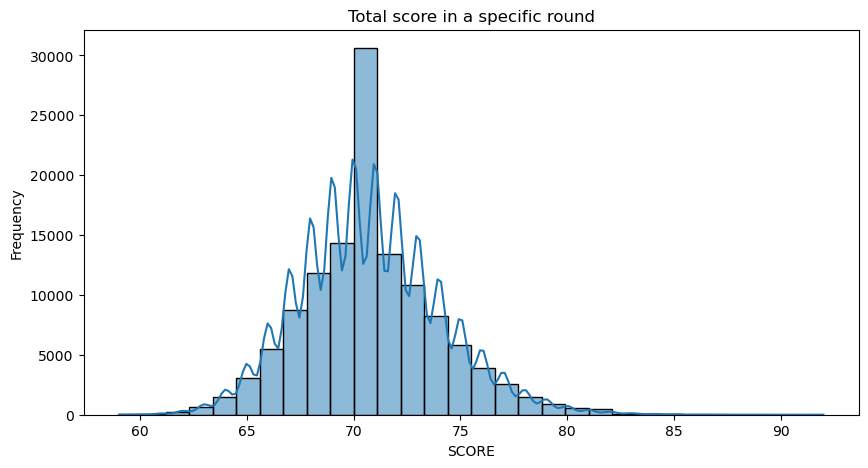

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(df['round_score'], kde=True, bins=30)
plt.title('Total score in a specific round')
plt.xlabel('SCORE')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Drop rows with missing target variable `round_score`
df_cleaned = df.dropna(subset=['round_score'])

<Axes: xlabel='round_num', ylabel='round_score'>

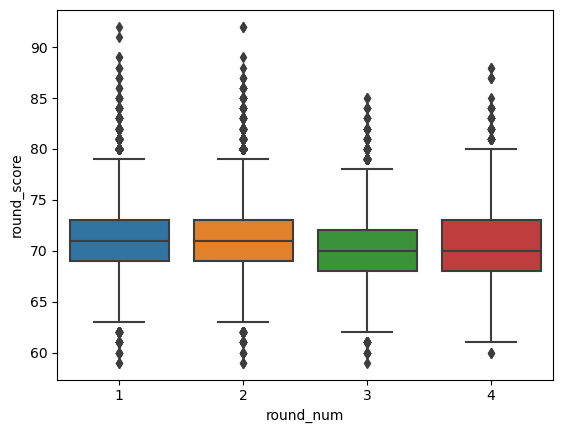

In [8]:
sns.boxplot(x=df_cleaned['round_num'],y=df_cleaned['round_score'])

In [9]:
dataset=df.dropna(subset=['round_score'])
dataset.shape

(125009, 34)

### Adding And Tournament Order Column Row Identifier
### We are reading a CSV file (`golf_events_sorted.csv`) into a DataFrame called `tournament_rankings`, then merging it with the existing `dataset` DataFrame using a left join on the columns `['year', 'event_name']`, and finally printing the shapes (dimensions) of both DataFrames.

In [10]:
tournament_rankings=pd.read_csv('golf_events_sorted.csv')
dataset=dataset.merge(tournament_rankings,how='left',on=['year','event_name'])
print(tournament_rankings.shape)
print(dataset.shape)

(322, 4)
,(125009, 36)


In [11]:
dataset[['year', 'tournament_order','event_id','dg_id','round_num']].drop_duplicates().shape

(125009, 5)

In [12]:
# Step 1: Sort by your required keys
dataset = dataset.sort_values(by=['year', 'tournament_order', 'event_id', 'dg_id', 'round_num']).reset_index(drop=True)

# Step 2: Add a row_id column
dataset['row_id'] = range(1, len(dataset) + 1)

# Optional: View a few rows to confirm

print(np.max(dataset['row_id']))

125009


In [13]:
# Assuming 'dataset' is your original DataFrame
one_hot = pd.get_dummies(dataset['round_num'], prefix='round')

# Concatenate one-hot encoded columns back to the original dataset
dataset = pd.concat([dataset, one_hot], axis=1)


## External Data for Weather Conditions

In [14]:
weather_data=pd.read_excel('weatherdata.xlsx')

In [15]:
weather_data.head(10)

,Tournament,Year,Start Date,Location,Avg Temp (°F),Humidity (%),Wind (mph),Notes
0,Sentry Tournament of Champions,2020,2025-01-02 00:00:00,"Kapalua, Maui, Hawaii",78°F,0.70,15 mph,"Warm, breezy (Maui)"
1,Sony Open in Hawaii,2020,2025-01-09 00:00:00,"Honolulu, Hawaii",77°F,0.72,12 mph,"Humid, occasional showers"
2,The American Express,2020,2025-01-16 00:00:00,"La Quinta, California",72°F,0.40,8 mph,Dry desert conditions
3,Farmers Insurance Open,2020,2025-01-23 00:00:00,"San Diego, California",65°F,0.55,10 mph,Cool coastal breezes
4,Waste Management Phoenix Open,2020,2025-01-30 00:00:00,"Scottsdale, Arizona",70°F,0.30,7 mph,"Dry, sunny"
5,AT&T Pebble Beach Pro-Am,2020,2025-02-06 00:00:00,"Pebble Beach, California",60°F,0.65,12 mph,"Cool, some marine fog"
6,The Genesis Invitational,2020,2025-02-13 00:00:00,"Pacific Palisades, California",68°F,0.50,8 mph,"Pleasant, sunny"
7,WGC-Mexico Championship,2020,2025-02-20 00:00:00,"Mexico City, Mexico",75°F,0.45,6 mph,"High altitude, mild"
8,Puerto Rico Open,2020,2025-02-20 00:00:00,"Rio Grande, Puerto Rico",80°F,0.75,14 mph,"Humid, breezy"
9,Honda Classic,2020,2025-02-27 00:00:00,"Palm Beach Gardens, Florida",78°F,0.65,10 mph,Windy Florida conditions


In [16]:

def fuzzy_left_join_best_match(
    df1,
    df2,
    on_exact_df1,
    on_exact_df2,
    on_fuzzy_df1,
    on_fuzzy_df2,
    threshold=75,
    return_score=False
):
    result_rows = []

    for _, row1 in df1.iterrows():
        # Step 1: Filter df2 by exact key
        exact_val = row1[on_exact_df1]
        df2_subset = df2[df2[on_exact_df2] == exact_val]

        if df2_subset.empty:
            # No match found; return row1 with NaNs for df2
            merged = row1.to_dict()
            for col in df2.columns:
                if col not in merged:
                    merged[col] = None
            if return_score:
                merged["match_score"] = None
            result_rows.append(merged)
            continue

        # Step 2: Fuzzy match within filtered subset
        match_results = [
            (idx, val, fuzz.token_sort_ratio(str(row1[on_fuzzy_df1]), str(val)))
            for idx, val in zip(df2_subset.index, df2_subset[on_fuzzy_df2])
        ]

        best_idx, best_val, best_score = max(match_results, key=lambda x: x[2])

        if best_score >= threshold:
            row2 = df2_subset.loc[best_idx]
            merged = {**row1.to_dict(), **row2.to_dict()}
            if return_score:
                merged["match_score"] = best_score
        else:
            # No sufficiently good match
            merged = row1.to_dict()
            for col in df2.columns:
                if col not in merged:
                    merged[col] = None
            if return_score:
                merged["match_score"] = best_score

        result_rows.append(merged)

    return pd.DataFrame(result_rows)

In [17]:
dataset = fuzzy_left_join_best_match(
    dataset,weather_data,
    on_exact_df1='year',
    on_exact_df2='Year',
    on_fuzzy_df1='event_name',
    on_fuzzy_df2='Tournament',
    threshold=50,
    return_score=True
)

In [18]:
dataset.shape

(125009, 50)

## Single Round Lag
### The SQL query calculates the previous round's statistics for various metrics (e.g., score, tee time, and performance) using the `LAG` window function, partitioned by player (`dg_id`) and ordered by tournament details. The result is stored in a DataFrame, and its shape (number of rows and columns) is displayed using `one_round_lag.shape`.

In [19]:
# Your clean SQL query in triple quotes
query = """
    SELECT
        row_id,
        tournament_order,
        year,
        event_id,
        dg_id,
        round_num,
        round_score,
        teetime_hour,
        lag(round_score, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_score,
        lag(teetime_hour, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS teetime_hour_score,
        lag(sg_putt, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_sg_putt,
        lag(sg_arg, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_sg_arg,
        lag(sg_app, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_sg_app,
        lag(sg_ott, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_sg_ott,
        lag(sg_t2g, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_sg_t2g,
        lag(sg_total, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_sg_total,
        lag(driving_dist, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_driving_dist,
        lag(driving_acc, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_driving_acc,
        lag(gir, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_gir,
        lag(scrambling, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_scrambling,
        lag(prox_rgh, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_prox_rgh,
        lag(prox_fw, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_prox_fw,
        lag(great_shots, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_great_shots,
        lag(poor_shots, 1) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num) AS last_poor_shots
    FROM
        dataset
"""

# Run the query using DuckDB
one_round_lag = duckdb.query(query).to_df()

# Display the result
one_round_lag.shape

(125009, 24)

In [20]:
dataset=dataset.merge(one_round_lag,how='left',on='row_id',suffixes=('','_one_round_lag')).sort_values(by='row_id')

## Last Tournament Same Round Values - ltrv
### The SQL query calculates previous round statistics for various metrics using the `LAG` function, partitioned by `dg_id` and `round_num`, and ordered by `year` and `tournament_order`. After running the query, redundant columns are dropped, leaving only the previous round's values in the resulting DataFrame `lesr`.

In [21]:
query = """
SELECT
    row_id,
    year,
    tournament_order,
    event_id,
    dg_id,
    round_num,
    round_score,
    teetime_hour,
    LAG(round_score, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS score_lesr,
    LAG(teetime_hour, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS teetime_hour_lesr,
    LAG(sg_putt, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS sg_putt_lesr,
    LAG(sg_arg, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS sg_arg_lesr,
    LAG(sg_app, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS sg_app_lesr,
    LAG(sg_ott, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS sg_ott_lesr,
    LAG(sg_t2g, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS sg_t2g_lesr,
    LAG(sg_total, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS sg_total_lesr,
    LAG(driving_dist, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS driving_dist_lesr,
    LAG(driving_acc, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS driving_acc_lesr,
    LAG(gir, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS gir_lesr,
    LAG(scrambling, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS scrambling_lesr,
    LAG(prox_rgh, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS prox_rgh_lesr,
    LAG(prox_fw, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS prox_fw_lesr,
    LAG(great_shots, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS great_shots_lesr,
    LAG(poor_shots, 1) OVER (PARTITION BY dg_id, round_num ORDER BY year, tournament_order, round_num) AS poor_shots_lesr
FROM
    dataset
"""

# Run the query using DuckDB
lesr = duckdb.query(query).to_df()

# Drop redundant columns
lesr = lesr.drop(['year', 'event_id', 'dg_id', 'round_num', 'round_score', 'teetime_hour'], axis=1)

# Display result
lesr

,row_id,tournament_order,score_lesr,teetime_hour_lesr,sg_putt_lesr,sg_arg_lesr,sg_app_lesr,sg_ott_lesr,sg_t2g_lesr,sg_total_lesr,driving_dist_lesr,driving_acc_lesr,gir_lesr,scrambling_lesr,prox_rgh_lesr,prox_fw_lesr,great_shots_lesr,poor_shots_lesr
0,44738,113,66.0,8.0,2.627,0.083,1.117,1.075,2.275,4.902,275.6,1.000,0.778,0.714,NaN,35.118,4.0,2.0
1,45482,115,69.0,8.0,0.588,0.151,2.023,-1.109,1.065,1.653,266.7,0.500,0.667,0.667,46.474,24.134,5.0,3.0
2,46395,117,69.0,12.0,0.420,-0.217,-0.027,0.376,0.131,0.551,287.9,0.786,0.778,0.400,22.669,31.632,4.0,5.0
3,46861,118,67.0,13.0,2.624,0.789,-0.991,0.193,-0.009,2.615,276.6,0.643,0.667,0.667,69.433,31.025,4.0,3.0
4,47324,119,72.0,8.0,-2.858,-0.722,1.623,0.573,1.475,-1.383,300.3,0.714,0.778,0.500,23.461,27.144,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125004,90926,236,70.0,11.0,0.740,0.774,0.687,-0.100,1.361,2.101,291.4,0.571,0.667,0.714,64.164,29.283,3.0,2.0
125005,92998,242,69.0,9.0,-2.018,2.245,1.949,-0.323,3.871,1.853,302.8,0.571,0.722,0.714,38.221,24.577,5.0,3.0
125006,94499,246,73.0,9.0,0.245,-0.328,-1.697,-0.317,-2.342,-2.097,275.5,0.615,0.444,0.692,58.346,29.014,3.0,6.0
125007,94889,247,69.0,12.0,0.166,0.815,-1.691,1.710,0.834,1.000,290.3,0.857,0.500,0.769,48.180,35.096,2.0,2.0


In [22]:
dataset=dataset.merge(lesr,how='left',on='row_id',suffixes=('','_lesr'))
dataset.shape

(125009, 90)

## Rolling Avg for past 3 round and past 5 rounds
### The SQL query calculates the average of various metrics over the last 3 and 5 rounds for each player (`dg_id`) using the `AVG` window function. The result is stored in the DataFrame `last_3and5_r_avg`, which contains the calculated averages for each metric.

In [23]:
query = """
SELECT
    row_id,
    
    -- Last 3 round averages
    AVG(sg_putt) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_putt_mean_3,
    AVG(sg_arg) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_arg_mean_3,
    AVG(sg_app) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_app_mean_3,
    AVG(sg_ott) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_ott_mean_3,
    AVG(sg_t2g) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_t2g_mean_3,
    AVG(sg_total) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_total_mean_3,
    AVG(driving_dist) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS driving_dist_mean_3,
    AVG(driving_acc) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS driving_acc_mean_3,
    AVG(gir) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS gir_mean_3,
    AVG(scrambling) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS scrambling_mean_3,
    AVG(prox_rgh) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS prox_rgh_mean_3,
    AVG(prox_fw) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS prox_fw_mean_3,
    AVG(great_shots) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS great_shots_mean_3,
    AVG(poor_shots) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS poor_shots_mean_3,
    AVG(round_score) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS round_score_mean_3,

    -- Last 5 round averages
    AVG(sg_putt) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_putt_avg_5,
    AVG(sg_arg) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_arg_avg_5,
    AVG(sg_app) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_app_avg_5,
    AVG(sg_ott) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_ott_avg_5,
    AVG(sg_t2g) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_t2g_avg_5,
    AVG(sg_total) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_total_avg_5,
    AVG(driving_dist) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS driving_dist_avg_5,
    AVG(driving_acc) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS driving_acc_avg_5,
    AVG(gir) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS gir_avg_5,
    AVG(scrambling) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS scrambling_avg_5,
    AVG(prox_rgh) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS prox_rgh_avg_5,
    AVG(prox_fw) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS prox_fw_avg_5,
    AVG(great_shots) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS great_shots_avg_5,
    AVG(poor_shots) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS poor_shots_avg_5,
    AVG(round_score) OVER (PARTITION BY dg_id ORDER BY year, tournament_order, round_num ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS round_score_avg_5

FROM dataset;
"""

# Run the query using DuckDB
last_3and5_r_avg = duckdb.query(query).to_df()

# Display the result
last_3and5_r_avg.shape

(125009, 31)

In [24]:
dataset=dataset.merge(last_3and5_r_avg,how='left',on='row_id',suffixes=('','_last_3and5_r_avg'))
dataset.shape

(125009, 120)

In [25]:
print("max:"+str(np.max(dataset['tournament_order'])))
print("min:"+str(np.min(dataset['tournament_order'])))

max:322
,min:1


## Last Tournaments(event_id) Avg performance 1, 3, 5, 10
### The query calculates rolling averages of various golf statistics (e.g., putting, driving accuracy, etc.) for each player across the last 1, 3, 5, and 10 tournaments. It first aggregates these stats per tournament, then uses window functions to compute the desired averages over preceding tournaments.

In [26]:
query = """
SELECT
    dg_id,
    tournament_order,
    event_id,
    year,
    -- Previous tournament (1 preceding)
    AVG(sg_putt_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS sg_putt_avg_last_1_tour,
    AVG(sg_arg_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS sg_arg_avg_last_1_tour,
    AVG(sg_app_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS sg_app_avg_last_1_tour,
    AVG(sg_ott_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS sg_ott_avg_last_1_tour,
    AVG(sg_t2g_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS sg_t2g_avg_last_1_tour,
    AVG(sg_total_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS sg_total_avg_last_1_tour,
    AVG(driving_dist_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS driving_dist_avg_last_1_tour,
    AVG(driving_acc_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS driving_acc_avg_last_1_tour,
    AVG(gir_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS gir_avg_last_1_tour,
    AVG(scrambling_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS scrambling_avg_last_1_tour,
    AVG(prox_rgh_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS prox_rgh_avg_last_1_tour,
    AVG(prox_fw_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS prox_fw_avg_last_1_tour,
    AVG(great_shots_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS great_shots_avg_last_1_tour,
    AVG(poor_shots_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS poor_shots_avg_last_1_tour,
    AVG(round_score_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) AS round_score_avg_last_1_tour,

    -- Last 3 tournaments
    AVG(sg_putt_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_putt_avg_last_3_tours,
    AVG(sg_arg_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_arg_avg_last_3_tours,
    AVG(sg_app_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_app_avg_last_3_tours,
    AVG(sg_ott_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_ott_avg_last_3_tours,
    AVG(sg_t2g_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_t2g_avg_last_3_tours,
    AVG(sg_total_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS sg_total_avg_last_3_tours,
    AVG(driving_dist_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS driving_dist_avg_last_3_tours,
    AVG(driving_acc_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS driving_acc_avg_last_3_tours,
    AVG(gir_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS gir_avg_last_3_tours,
    AVG(scrambling_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS scrambling_avg_last_3_tours,
    AVG(prox_rgh_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS prox_rgh_avg_last_3_tours,
    AVG(prox_fw_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS prox_fw_avg_last_3_tours,
    AVG(great_shots_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS great_shots_avg_last_3_tours,
    AVG(poor_shots_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS poor_shots_avg_last_3_tours,
    AVG(round_score_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS round_score_avg_last_3_tours,

    -- Last 5 tournaments
    AVG(sg_putt_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_putt_avg_last_5_tours,
    AVG(sg_arg_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_arg_avg_last_5_tours,
    AVG(sg_app_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_app_avg_last_5_tours,
    AVG(sg_ott_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_ott_avg_last_5_tours,
    AVG(sg_t2g_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_t2g_avg_last_5_tours,
    AVG(sg_total_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS sg_total_avg_last_5_tours,
    AVG(driving_dist_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS driving_dist_avg_last_5_tours,
    AVG(driving_acc_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS driving_acc_avg_last_5_tours,
    AVG(gir_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS gir_avg_last_5_tours,
    AVG(scrambling_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS scrambling_avg_last_5_tours,
    AVG(prox_rgh_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS prox_rgh_avg_last_5_tours,
    AVG(prox_fw_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS prox_fw_avg_last_5_tours,
    AVG(great_shots_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS great_shots_avg_last_5_tours,
    AVG(poor_shots_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS poor_shots_avg_last_5_tours,
    AVG(round_score_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS round_score_avg_last_5_tours,

    -- Last 10 tournaments
    AVG(sg_putt_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS sg_putt_avg_last_10_tours,
    AVG(sg_arg_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS sg_arg_avg_last_10_tours,
    AVG(sg_app_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS sg_app_avg_last_10_tours,
    AVG(sg_ott_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS sg_ott_avg_last_10_tours,
    AVG(sg_t2g_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS sg_t2g_avg_last_10_tours,
    AVG(sg_total_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS sg_total_avg_last_10_tours,
    AVG(driving_dist_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS driving_dist_avg_last_10_tours,
    AVG(driving_acc_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS driving_acc_avg_last_10_tours,
    AVG(gir_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS gir_avg_last_10_tours,
    AVG(scrambling_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS scrambling_avg_last_10_tours,
    AVG(prox_rgh_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS prox_rgh_avg_last_10_tours,
    AVG(prox_fw_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS prox_fw_avg_last_10_tours,
    AVG(great_shots_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS great_shots_avg_last_10_tours,
    AVG(poor_shots_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS poor_shots_avg_last_10_tours,
    AVG(round_score_avg) OVER (PARTITION BY dg_id ORDER BY tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) AS round_score_avg_last_10_tours

FROM (
    SELECT
        dg_id,
        tournament_order,
        year,
        event_id,
        AVG(sg_putt) AS sg_putt_avg,
        AVG(sg_arg) AS sg_arg_avg,
        AVG(sg_app) AS sg_app_avg,
        AVG(sg_ott) AS sg_ott_avg,
        AVG(sg_t2g) AS sg_t2g_avg,
        AVG(sg_total) AS sg_total_avg,
        AVG(driving_dist) AS driving_dist_avg,
        AVG(driving_acc) AS driving_acc_avg,
        AVG(gir) AS gir_avg,
        AVG(scrambling) AS scrambling_avg,
        AVG(prox_rgh) AS prox_rgh_avg,
        AVG(prox_fw) AS prox_fw_avg,
        AVG(great_shots) AS great_shots_avg,
        AVG(poor_shots) AS poor_shots_avg,
        AVG(round_score) AS round_score_avg
    FROM dataset
    GROUP BY dg_id, year, tournament_order,event_id
) AS tournament_summary;
"""

# Run the query
last_tournaments = duckdb.query(query).to_df()

# Display
last_tournaments


,dg_id,tournament_order,event_id,year,sg_putt_avg_last_1_tour,sg_arg_avg_last_1_tour,sg_app_avg_last_1_tour,sg_ott_avg_last_1_tour,sg_t2g_avg_last_1_tour,sg_total_avg_last_1_tour,driving_dist_avg_last_1_tour,driving_acc_avg_last_1_tour,gir_avg_last_1_tour,scrambling_avg_last_1_tour,prox_rgh_avg_last_1_tour,prox_fw_avg_last_1_tour,great_shots_avg_last_1_tour,poor_shots_avg_last_1_tour,round_score_avg_last_1_tour,sg_putt_avg_last_3_tours,sg_arg_avg_last_3_tours,sg_app_avg_last_3_tours,sg_ott_avg_last_3_tours,sg_t2g_avg_last_3_tours,sg_total_avg_last_3_tours,driving_dist_avg_last_3_tours,driving_acc_avg_last_3_tours,gir_avg_last_3_tours,scrambling_avg_last_3_tours,prox_rgh_avg_last_3_tours,prox_fw_avg_last_3_tours,great_shots_avg_last_3_tours,poor_shots_avg_last_3_tours,round_score_avg_last_3_tours,sg_putt_avg_last_5_tours,sg_arg_avg_last_5_tours,sg_app_avg_last_5_tours,sg_ott_avg_last_5_tours,sg_t2g_avg_last_5_tours,sg_total_avg_last_5_tours,driving_dist_avg_last_5_tours,driving_acc_avg_last_5_tours,gir_avg_last_5_tours,scrambling_avg_last_5_tours,prox_rgh_avg_last_5_tours,prox_fw_avg_last_5_tours,great_shots_avg_last_5_tours,poor_shots_avg_last_5_tours,round_score_avg_last_5_tours,sg_putt_avg_last_10_tours,sg_arg_avg_last_10_tours,sg_app_avg_last_10_tours,sg_ott_avg_last_10_tours,sg_t2g_avg_last_10_tours,sg_total_avg_last_10_tours,driving_dist_avg_last_10_tours,driving_acc_avg_last_10_tours,gir_avg_last_10_tours,scrambling_avg_last_10_tours,prox_rgh_avg_last_10_tours,prox_fw_avg_last_10_tours,great_shots_avg_last_10_tours,poor_shots_avg_last_10_tours,round_score_avg_last_10_tours
0,294,14,14,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,294,28,100,2017,NaN,NaN,NaN,NaN,NaN,-5.1400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,-5.140000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN,NaN,-5.140000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN,NaN,-5.140000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.000000
2,294,60,14,2018,NaN,NaN,NaN,NaN,NaN,-3.5255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.5,NaN,NaN,NaN,NaN,NaN,-4.332750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.250000,NaN,NaN,NaN,NaN,NaN,-4.332750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.250000,NaN,NaN,NaN,NaN,NaN,-4.332750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.250000
3,294,74,100,2018,NaN,NaN,NaN,NaN,NaN,-0.8220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN,NaN,-3.162500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.166667,NaN,NaN,NaN,NaN,NaN,-3.162500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.166667,NaN,NaN,NaN,NaN,NaN,-3.162500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.166667
4,294,108,14,2019,NaN,NaN,NaN,NaN,NaN,-2.5170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.5,NaN,NaN,NaN,NaN,NaN,-2.288167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.666667,NaN,NaN,NaN,NaN,NaN,-3.001125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.750000,NaN,NaN,NaN,NaN,NaN,-3.001125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40179,30891,301,26,2023,-0.216,0.1135,-0.575,0.6565,0.195,-0.0210,311.55,0.615,0.639,0.6,44.9925,40.449,5.0,5.0,70.5,-0.216,0.1135,-0.575,0.6565,0.195,-0.021000,311.55,0.615,0.639,0.6,44.9925,40.449,5.0,5.0,70.500000,-0.216,0.1135,-0.575,0.6565,0.195,-0.021000,311.55,0.615,0.639,0.6,44.9925,40.449,5.0,5.0,70.500000,-0.216,0.1135,-0.575,0.6565,0.195,-0.021000,311.55,0.615,0.639,0.6,44.9925,40.449,5.0,5.0,70.500000
40180,31160,300,32,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4

In [27]:
dataset=dataset.merge(last_tournaments,how='left',on=['dg_id','year','event_id','tournament_order'],suffixes=('','_last_tournament'))
dataset.shape

(125009, 180)

## Nth Tournament of the Year
### The query calculates the "year-to-date" (YTD) tournament count for each player (`dg_id`) by assigning a dense rank based on the `tournament_order` within each year (`year`). It uses the `dense_rank()` window function to determine the rank of each tournament within the same year and partitioned by `dg_id`. The result is a dataset that includes the `row_id` along with the computed YTD tournament count for each player across different tournaments.

In [28]:
# Your clean SQL query in triple quotes
query = """
SELECT
    row_id,
    dense_rank() OVER (PARTITION BY dg_id, year ORDER BY tournament_order) AS ytd_tournament_counts
FROM dataset;


"""

# Run the query using DuckDB
ytd_nth_tournament = duckdb.query(query).to_df()


# Display the result
ytd_nth_tournament.head(5)

,row_id,ytd_tournament_counts
0,76026,1
1,76027,1
2,23804,1
3,23805,1
4,11309,1


In [29]:
dataset=dataset.merge(ytd_nth_tournament,how='left',on=['row_id'],suffixes=('',''))
dataset.shape

(125009, 181)

In [30]:
print("Shape of the dataset: "+ str(dataset.shape))
print("Columns in the dataset: "+ str(dataset.columns))

Shape of the dataset: (125009, 181)
,Columns in the dataset: Index(['tour', 'year', 'season', 'event_name', 'event_id', 'player_name',
,       'dg_id', 'fin_text', 'round_num', 'course_name',
,       ...
,       'driving_dist_avg_last_10_tours', 'driving_acc_avg_last_10_tours',
,       'gir_avg_last_10_tours', 'scrambling_avg_last_10_tours',
,       'prox_rgh_avg_last_10_tours', 'prox_fw_avg_last_10_tours',
,       'great_shots_avg_last_10_tours', 'poor_shots_avg_last_10_tours',
,       'round_score_avg_last_10_tours', 'ytd_tournament_counts'],
,      dtype='object', length=181)


In [31]:
pd.set_option('display.max_colwidth', None)


In [32]:
dataset.tail()

,tour,year,season,event_name,event_id,player_name,dg_id,fin_text,round_num,course_name,course_num,course_par,start_hole,teetime,round_score,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,driving_dist,driving_acc,gir,scrambling,prox_rgh,prox_fw,great_shots,poor_shots,country_code,country,amateur,teetime_parsed,teetime_hour,New Date,tournament_order,row_id,round_1,round_2,round_3,round_4,Tournament,Year,Start Date,Location,Avg Temp (°F),Humidity (%),Wind (mph),Notes,match_score,tournament_order_one_round_lag,year_one_round_lag,event_id_one_round_lag,dg_id_one_round_lag,round_num_one_round_lag,round_score_one_round_lag,teetime_hour_one_round_lag,last_score,teetime_hour_score,last_sg_putt,last_sg_arg,last_sg_app,last_sg_ott,last_sg_t2g,last_sg_total,last_driving_dist,last_driving_acc,last_gir,last_scrambling,last_prox_rgh,last_prox_fw,last_great_shots,last_poor_shots,tournament_order_lesr,score_lesr,teetime_hour_lesr,sg_putt_lesr,sg_arg_lesr,sg_app_lesr,sg_ott_lesr,sg_t2g_lesr,sg_total_lesr,driving_dist_lesr,driving_acc_lesr,gir_lesr,scrambling_lesr,prox_rgh_lesr,prox_fw_lesr,great_shots_lesr,poor_shots_lesr,sg_putt_mean_3,sg_arg_mean_3,sg_app_mean_3,sg_ott_mean_3,sg_t2g_mean_3,sg_total_mean_3,driving_dist_mean_3,driving_acc_mean_3,gir_mean_3,scrambling_mean_3,prox_rgh_mean_3,prox_fw_mean_3,great_shots_mean_3,poor_shots_mean_3,round_score_mean_3,sg_putt_avg_5,sg_arg_avg_5,sg_app_avg_5,sg_ott_avg_5,sg_t2g_avg_5,sg_total_avg_5,driving_dist_avg_5,driving_acc_avg_5,gir_avg_5,scrambling_avg_5,prox_rgh_avg_5,prox_fw_avg_5,great_shots_avg_5,poor_shots_avg_5,round_score_avg_5,sg_putt_avg_last_1_tour,sg_arg_avg_last_1_tour,sg_app_avg_last_1_tour,sg_ott_avg_last_1_tour,sg_t2g_avg_last_1_tour,sg_total_avg_last_1_tour,driving_dist_avg_last_1_tour,driving_acc_avg_last_1_tour,gir_avg_last_1_tour,scrambling_avg_last_1_tour,prox_rgh_avg_last_1_tour,prox_fw_avg_last_1_tour,great_shots_avg_last_1_tour,poor_shots_avg_last_1_tour,round_score_avg_last_1_tour,sg_putt_avg_last_3_tours,sg_arg_avg_last_3_tours,sg_app_avg_last_3_tours,sg_ott_avg_last_3_tours,sg_t2g_avg_last_3_tours,sg_total_avg_last_3_tours,driving_dist_avg_last_3_tours,driving_acc_avg_last_3_tours,gir_avg_last_3_tours,scrambling_avg_last_3_tours,prox_rgh_avg_last_3_tours,prox_fw_avg_last_3_tours,great_shots_avg_last_3_tours,poor_shots_avg_last_3_tours,round_score_avg_last_3_tours,sg_putt_avg_last_5_tours,sg_arg_avg_last_5_tours,sg_app_avg_last_5_tours,sg_ott_avg_last_5_tours,sg_t2g_avg_last_5_tours,sg_total_avg_last_5_tours,driving_dist_avg_last_5_tours,driving_acc_avg_last_5_tours,gir_avg_last_5_tours,scrambling_avg_last_5_tours,prox_rgh_avg_last_5_tours,prox_fw_avg_last_5_tours,great_shots_avg_last_5_tours,poor_shots_avg_last_5_tours,round_score_avg_last_5_tours,sg_putt_avg_last_10_tours,sg_arg_avg_last_10_tours,sg_app_avg_last_10_tours,sg_ott_avg_last_10_tours,sg_t2g_avg_last_10_tours,sg_total_avg_last_10_tours,driving_dist_avg_last_10_tours,driving_acc_avg_last_10_tours,gir_avg_last_10_tours,scrambling_avg_last_10_tours,prox_rgh_avg_last_10_tours,prox_fw_avg_last_10_tours,great_shots_avg_last_10_tours,poor_shots_avg_last_10_tours,round_score_avg_last_10_tours,ytd_tournament_counts
125004,pga,2023,2023,PGA TOUR Q-School presented by Korn Ferry,88,"Hofman, Noah",31420,T92,4,Dye's Valley Course,922,70,10,10:30AM,72.0,NaN,NaN,NaN,NaN,NaN,-1.405,NaN,0.500,NaN,NaN,NaN,NaN,NaN,NaN,USA,United States,0.0,10:30:00,10,14-12-2023,322,125005,0,0,0,1,PGA TOUR Q-School presented by Korn Ferry,2023.0,2025-12-14 00:00:00,"Ponte Vedra Beach, Florida, USA",67°F,0.7,20 mph,"Cool, coastal fog",100.0,322,2023,88,31420,4,72.0,10,71.0,9.0,NaN,NaN,NaN,NaN,NaN,-0.333,NaN,0.500,NaN,NaN,NaN,NaN,NaN,NaN,322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213000,NaN,0.452333,NaN,NaN,NaN,NaN,NaN,NaN,71.0,-2.561,-2.6635,-2.98,-2.9655,-8.609,-4.340200,287.15,0.4714,0.472,0.254,73.6685,38.0645,2.0,12.0,75.0,-2.561,-2.6635,-2.98,-2.9655,-8.609,-11.17,287.15,0.5,0.472,0.254,73.6685,38

# Function to Clean and Extract Temperature Data from Strings
### The `clean_temperature()` function extracts the numerical value from a temperature string (e.g., "71°F") or returns NaN for invalid inputs. It is applied to the `Avg Temp (°F)` column in the dataset to create a new `cleaned_temperature` column.

In [33]:
def clean_temperature(temp_str):
  """
  Cleans a temperature string (e.g. "71°F") and extracts the numerical value as a float.
  Handles cases where the input is already a number.

  Args:
    temp_str: The temperature string or number.

  Returns:
    A float representing the temperature, or NaN if the string cannot be parsed.
  """
  try:
    if isinstance(temp_str, (int, float)):
      return float(temp_str)  # Already a number, convert to float
    else:
      temp_str = str(temp_str).replace("°F", "").strip()
      return float(temp_str)
  except (ValueError, TypeError):
    return float('nan')  # Return NaN for invalid input


# Apply the function to create a new column with cleaned temperature values
dataset['cleaned_temperature'] = dataset['Avg Temp (°F)'].apply(clean_temperature)

# Function to Clean and Extract Wind Speed Data from Strings
### The `clean_wind_speed()` function extracts the numerical value from wind speed strings (e.g., "10 mph") or returns NaN for invalid inputs. It is applied to the 'Wind (mph)' column in the dataset to create a new 'cleaned_wind_speed' column.

In [34]:
def clean_wind_speed(wind_str):
    """
    Cleans a wind speed string (e.g., "10 mph") and extracts the numerical value as a float.

    Args:
        wind_str: The wind speed string.

    Returns:
        A float representing the wind speed, or NaN if the string cannot be parsed.
    """
    try:
        if isinstance(wind_str, (int, float)):
          return float(wind_str)
        else:
          return float(str(wind_str).split()[0])
    except (ValueError, IndexError, AttributeError):
        return float('nan')

# Assuming your DataFrame is named 'weather_df' and the column with wind speed is named 'wind_speed'
# Replace 'wind_speed' with the actual column name if it's different.

# Example usage (assuming 'weather_df' and 'wind_speed' column exist):
# Create a sample DataFrame (replace with your actual DataFrame)
data = {'wind_speed': ['10 mph', '15 mph', '20 mph', 'invalid', 25]}
weather_df = pd.DataFrame(data)

dataset['cleaned_wind_speed'] = dataset['Wind (mph)'].apply(clean_wind_speed)

In [35]:
dataset.shape

(125009, 183)

# Weather Conditions Matrix Extraction

### This code creates a weather condition matrix by analyzing weather-related keywords in the "Notes" column. It generates boolean columns for conditions like sunny, raining, foggy, and more based on the presence of these keywords

In [36]:
# prompt: the notes list has weather info,
# I need to create a 1/0 matrix on columns like sunny, raining, foggy, humid etc based on what is in notes
# The end result is a dataframe with notes column and other columns which are boolean describing the weather
# Show all columns

notes=dataset[(dataset['year']>=2019)]['Notes'].unique()

# Create a dictionary to store the weather conditions
weather_dict = {
    'notes': notes,
    'sunny': [1 if 'sunny' in note.lower() or 'sun' in note.lower() else 0 for note in notes],
    'raining': [1 if 'rain' in note.lower() or 'showers' in note.lower() or 'storms' in note.lower() else 0 for note in notes],
    'foggy': [1 if 'fog' in note.lower() else 0 for note in notes],
    'humid': [1 if 'humid' in note.lower() or 'sticky' in note.lower() or 'muggy' in note.lower() else 0 for note in notes],
    'breezy': [1 if 'breeze' in note.lower() or 'breezy' in note.lower() or 'windy' in note.lower() else 0 for note in notes],
    'dry': [1 if 'dry' in note.lower() or 'desert' in note.lower() else 0 for note in notes],
    'warm': [1 if 'warm' in note.lower() else 0 for note in notes],
    'hot': [1 if 'hot' in note.lower() else 0 for note in notes],
    'cool': [1 if 'cool' in note.lower() else 0 for note in notes],
    'mild': [1 if 'mild' in note.lower() else 0 for note in notes],
    'coastal': [1 if 'coastal' in note.lower() or 'ocean' in note.lower() or 'marine' in note.lower() else 0 for note in notes],
    'tropical': [1 if 'tropical' in note.lower() else 0 for note in notes]
}


# Create a pandas DataFrame from the dictionary
weather_df = pd.DataFrame(weather_dict)


# Display all columns of the DataFrame
weather_df.head(20)


,notes,sunny,raining,foggy,humid,breezy,dry,warm,hot,cool,mild,coastal,tropical
0,"Breezy, warm",0,0,0,0,1,0,1,0,0,0,0,0
1,"Humid, ocean breezes",0,0,0,1,1,0,0,0,0,0,1,0
2,Dry desert conditions,0,0,0,0,0,1,0,0,0,0,0,0
3,Mild coastal air,0,0,0,0,0,0,0,0,0,1,1,0
4,Dry and sunny,1,0,0,0,0,1,0,0,0,0,0,0
5,"Cool, coastal fog",0,0,1,0,0,0,0,0,1,0,1,0
6,"Sunny, pleasant",1,0,0,0,0,0,0,0,0,0,0,0
7,"Mild, high altitude",0,0,0,0,0,0,0,0,0,1,0,0
8,Tropical humidity,0,0,0,1,0,0,0,0,0,0,0,1
9,"Warm, chance of rain",0,1,0,0,0,0,1,0,0,0,0,0


In [37]:
dataset=dataset.merge(weather_df,how='left',left_on='Notes',right_on='notes')
dataset.shape

(125009, 196)

## New Calculated features like:

### Weighted Proximity, Weighted Proximity x SG_PUTT
### Temp x SG Putt
### Wind x Distance
### Humidity x Proxmity

In [38]:
# Mapping time tags to exact column names in your dataset
time_mappings = {
    'last': {
        'fw': 'last_prox_fw',
        'rgh': 'last_prox_rgh',
        'acc': 'last_driving_acc',
        'sg_putt': 'last_sg_putt'
    },
    'lesr': {
        'fw': 'prox_fw_lesr',
        'rgh': 'prox_rgh_lesr',
        'acc': 'driving_acc_lesr',
        'sg_putt': 'sg_putt_lesr'
    },
    'mean_3': {
        'fw': 'prox_fw_mean_3',
        'rgh': 'prox_rgh_mean_3',
        'acc': 'driving_acc_mean_3',
        'sg_putt': 'sg_putt_mean_3'
    },
    'avg_5': {
        'fw': 'prox_fw_avg_5',
        'rgh': 'prox_rgh_avg_5',
        'acc': 'driving_acc_avg_5',
        'sg_putt': 'sg_putt_avg_5'
    },
    'avg_last_1_tour': {
        'fw': 'prox_fw_avg_last_1_tour',
        'rgh': 'prox_rgh_avg_last_1_tour',
        'acc': 'driving_acc_avg_last_1_tour',
        'sg_putt': 'sg_putt_avg_last_1_tour'
    },
    'avg_last_3_tours': {
        'fw': 'prox_fw_avg_last_3_tours',
        'rgh': 'prox_rgh_avg_last_3_tours',
        'acc': 'driving_acc_avg_last_3_tours',
        'sg_putt': 'sg_putt_avg_last_3_tours'
    },
    'avg_last_5_tours': {
        'fw': 'prox_fw_avg_last_5_tours',
        'rgh': 'prox_rgh_avg_last_5_tours',
        'acc': 'driving_acc_avg_last_5_tours',
        'sg_putt': 'sg_putt_avg_last_5_tours'
    },
    'avg_last_10_tours': {
        'fw': 'prox_fw_avg_last_10_tours',
        'rgh': 'prox_rgh_avg_last_10_tours',
        'acc': 'driving_acc_avg_last_10_tours',
        'sg_putt': 'sg_putt_avg_last_10_tours'
    }
}

# Generate weighted proximity and interaction features
for tag, cols in time_mappings.items():
    fw_col = cols['fw']
    rgh_col = cols['rgh']
    acc_col = cols['acc']
    sg_col = cols['sg_putt']

    weighted_prox_col = f'weighted_proximity_{tag}'
    interaction_col = f'weighted_proximity_x_sg_putt_{tag}'

    dataset[weighted_prox_col] = dataset[acc_col] * dataset[fw_col] + (1 - dataset[acc_col]) * dataset[rgh_col]
    dataset[interaction_col] = dataset[weighted_prox_col] * dataset[sg_col]


# Creating Interaction Features for Weather and Golf Data

### This code generates interaction features by combining weather-related data (wind speed, humidity, temperature) with various golf statistics (driving distance, SG putting, weighted proximity) for different time horizons. Each time horizon creates specific interaction columns in the dataset, facilitating advanced analysis.

In [39]:
# Define the time horizon suffixes
time_horizons = [
    'last',
    'lesr',
    'mean_3',
    'avg_5',
    'avg_last_1_tour',
    'avg_last_3_tours',
    'avg_last_5_tours',
    'avg_last_10_tours'
]

# Loop and create interaction features
for tag in time_horizons:
    # Driving distance
    driving_dist_col = f'driving_dist_{tag}' if tag != 'last' else 'last_driving_dist'

    # SG Putting
    sg_putt_col = f'sg_putt_{tag}' if tag != 'last' else 'last_sg_putt'

    # Weighted proximity
    weighted_prox_col = f'weighted_proximity_{tag}'

    # Interaction features
    dataset[f'wind_x_driving_dist_{tag}'] = dataset['cleaned_wind_speed'] * dataset[driving_dist_col]
    dataset[f'humidity_x_weighted_prox_{tag}'] = dataset['Humidity (%)'] * dataset[weighted_prox_col]
    dataset[f'temp_x_sg_putt_{tag}'] = dataset['cleaned_temperature'] * dataset[sg_putt_col]

## Course Historic Data
### This code applies a mapping to normalize messy or inconsistent course names in the dataset, ensuring that different variations of the same course name are standardized. The course_name_mapping dictionary maps known variations to a consistent name, which is then applied to the course_name column to create a course_name_normalized column

In [40]:
# Standardisaing Course name

# Updated mapping for all known messy names
course_name_mapping = {
    # Bay Hill
    "Arnold Palmer's Bay Hill Club & Lodge": "Bay Hill Club & Lodge",

    # Pebble Beach group
    "Pebble Beach GL": "Pebble Beach Golf Links",
    "Spyglass Hill GC": "Spyglass Hill Golf Course",
    "Spyglass Hill Golf Course": "Spyglass Hill Golf Course",
    "Pebble Beach Golf Links": "Pebble Beach Golf Links",
    "Monterey Peninsula CC": "Monterey Peninsula Country Club",

    # Keene Trace
    "Keene Trace Golf Club": "Keene Trace Golf Club (Champions Course)",

    # Tahoe Mountain Club
    "Old Greenwood Golf Course at Tahoe Mountain Club": "Old Greenwood (Tahoe Mountain Club)",
    "Tahoe Mt. Club (Old Greenwood)": "Old Greenwood (Tahoe Mountain Club)",
    "Tahoe Mountain Club (Old Greenwood)": "Old Greenwood (Tahoe Mountain Club)",

    # Torrey Pines
    "Torrey Pines GC (South)": "Torrey Pines (South)",
    "Torrey Pines (South)": "Torrey Pines (South)",
    "Torrey Pines GC (North)": "Torrey Pines (North)",
    "Torrey Pines (North)": "Torrey Pines (North)",
    "Torrey Pines Golf Course (North Course)": "Torrey Pines (North)",
    "Torrey Pines Golf Course (South Course)": "Torrey Pines (South)",

    # Silverado
    "Silverado Resort and Spa North": "Silverado Resort & Spa (North)",
    "Silverado Resort and Spa (North Course)": "Silverado Resort & Spa (North)",

    # Sea Island
    "Sea Island Resort (Plantation)": "Sea Island Golf Club (Plantation Course)",
    "Sea Island Resort (Seaside)": "Sea Island Golf Club (Seaside Course)",
    "Sea Island GC (Plantation)": "Sea Island Golf Club (Plantation Course)",
    "Sea Island GC (Seaside)": "Sea Island Golf Club (Seaside Course)",
    "Sea Island Golf Club (Plantation)": "Sea Island Golf Club (Plantation Course)",
    "Sea Island Golf Club (Seaside)": "Sea Island Golf Club (Seaside Course)",
    
    # Riviera
    "Riviera CC": "Riviera Country Club",
    "The Riviera Country Club": "Riviera Country Club",

    # Albany
    "Albany GC": "Albany",
    "Albany, Bahamas": "Albany",

    # Waialae
    "Waialae CC": "Waialae Country Club",

    # Sedgefield
    "Sedgefield CC": "Sedgefield Country Club",

    # Accordia
    "Accordia Golf Narashino CC": "Accordia Golf Narashino Country Club",

    # TPC San Antonio
    "TPC San Antonio (Oaks Course)": "TPC San Antonio - AT&T Oaks",

    # Sawgrass
    "TPC Sawgrass (THE PLAYERS Stadium Course)": "TPC Sawgrass",

    # Coralès
    "Puntacana Resort & Club (Corales Golf Course)": "Corales Golf Club",

    # Houston Golf Club
    "GC of Houston": "Golf Club of Houston",
    
    # La Quinta
    "La Quinta CC": "La Quinta Country Club",
    
    # Nine Bridges
    "Nine Bridges": "Club at Nine Bridges",
    
    # Harbour Town
    "Harbour Town GL": "Harbour Town Golf Links",
    
    # Muirfield Village
    "Muirfield Village GC": "Muirfield Village Golf Club",
    
    # East Lake
    "East Lake GC": "East Lake Golf Club",
    
    # Sheshan International
    "Sheshan International GC": "Sheshan International Golf Club",

    # Club de Golf Chapultepec
    "Club de Golf Chapultepec": "Club de Golf Chapultepec",

    # Congaree
    "Congaree Golf Club": "Congaree Golf Club",

    # El Camaleon
    "El Camaleon GC": "El Camaleon Golf Club",
    "El CamaleÃƒÂ³n Golf Course at Mayakoba": "El Camaleon Golf Club",
}

# Apply normalization
dataset['course_name_normalized'] = dataset['course_name'].apply(lambda x: course_name_mapping.get(x, x))


# Rolling and Lagged Averages of Golf Metrics by Course and Year

### This query computes lag values and rolling averages (for the last 1, 3, and 5 years) of various golf metrics, grouped by course and year. The result includes calculated averages for each metric (e.g., round score, driving distance, SG stats) across the specified time horizons.

In [41]:
query = """
SELECT
    t1.course_name AS course_name_normalized,
    t1.year,

    -- Previous year values (lag 1)
    LAG(t1.avg_round_score, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_round_score_course_avg,
    LAG(t1.avg_sg_putt, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_sg_putt_course_avg,
    LAG(t1.avg_sg_arg, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_sg_arg_course_avg,
    LAG(t1.avg_sg_app, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_sg_app_course_avg,
    LAG(t1.avg_sg_ott, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_sg_ott_course_avg,
    LAG(t1.avg_sg_t2g, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_sg_t2g_course_avg,
    LAG(t1.avg_sg_total, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_sg_total_course_avg,
    LAG(t1.avg_driving_dist, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_driving_dist_course_avg,
    LAG(t1.avg_driving_acc, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_driving_acc_course_avg,
    LAG(t1.avg_gir, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_gir_course_avg,
    LAG(t1.avg_scrambling, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_scrambling_course_avg,
    LAG(t1.avg_prox_rgh, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_prox_rgh_course_avg,
    LAG(t1.avg_prox_fw, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_prox_fw_course_avg,
    LAG(t1.avg_great_shots, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_great_shots_course_avg,
    LAG(t1.avg_poor_shots, 1) OVER (PARTITION BY t1.course_name ORDER BY t1.year) AS last_1_year_poor_shots_course_avg,

    -- 3-year rolling AVERAGE (strictly past 3 years)
    AVG(t1.avg_round_score) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_round_score_course_avg,
    AVG(t1.avg_sg_putt) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_sg_putt_course_avg,
    AVG(t1.avg_sg_arg) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_sg_arg_course_avg,
    AVG(t1.avg_sg_app) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_sg_app_course_avg,
    AVG(t1.avg_sg_ott) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_sg_ott_course_avg,
    AVG(t1.avg_sg_t2g) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_sg_t2g_course_avg,
    AVG(t1.avg_sg_total) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_sg_total_course_avg,
    AVG(t1.avg_driving_dist) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_driving_dist_course_avg,
    AVG(t1.avg_driving_acc) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_driving_acc_course_avg,
    AVG(t1.avg_gir) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_gir_course_avg,
    AVG(t1.avg_scrambling) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_scrambling_course_avg,
    AVG(t1.avg_prox_rgh) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_prox_rgh_course_avg,
    AVG(t1.avg_prox_fw) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_prox_fw_course_avg,
    AVG(t1.avg_great_shots) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_great_shots_course_avg,
    AVG(t1.avg_poor_shots) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS last_3_year_poor_shots_course_avg,

    -- 5-year rolling AVERAGE (strictly past 5 years)
    AVG(t1.avg_round_score) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_round_score_course_avg,
    AVG(t1.avg_sg_putt) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_sg_putt_course_avg,
    AVG(t1.avg_sg_arg) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_sg_arg_course_avg,
    AVG(t1.avg_sg_app) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_sg_app_course_avg,
    AVG(t1.avg_sg_ott) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_sg_ott_course_avg,
    AVG(t1.avg_sg_t2g) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_sg_t2g_course_avg,
    AVG(t1.avg_sg_total) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_sg_total_course_avg,
    AVG(t1.avg_driving_dist) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_driving_dist_course_avg,
    AVG(t1.avg_driving_acc) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_driving_acc_course_avg,
    AVG(t1.avg_gir) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_gir_course_avg,
    AVG(t1.avg_scrambling) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_scrambling_course_avg,
    AVG(t1.avg_prox_rgh) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_prox_rgh_course_avg,
    AVG(t1.avg_prox_fw) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_prox_fw_course_avg,
    AVG(t1.avg_great_shots) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_great_shots_course_avg,
    AVG(t1.avg_poor_shots) OVER (PARTITION BY t1.course_name ORDER BY t1.year ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING) AS last_5_year_poor_shots_course_avg

FROM (
    SELECT 
        course_name_normalized AS course_name,
        year,
        AVG(round_score) AS avg_round_score,
        AVG(sg_putt) AS avg_sg_putt,
        AVG(sg_arg) AS avg_sg_arg,
        AVG(sg_app) AS avg_sg_app,
        AVG(sg_ott) AS avg_sg_ott,
        AVG(sg_t2g) AS avg_sg_t2g,
        AVG(sg_total) AS avg_sg_total,
        AVG(driving_dist) AS avg_driving_dist,
        AVG(driving_acc) AS avg_driving_acc,
        AVG(gir) AS avg_gir,
        AVG(scrambling) AS avg_scrambling,
        AVG(prox_rgh) AS avg_prox_rgh,
        AVG(prox_fw) AS avg_prox_fw,
        AVG(great_shots) AS avg_great_shots,
        AVG(poor_shots) AS avg_poor_shots
    FROM 
        dataset
    GROUP BY 
        course_name_normalized,
        year
) t1
ORDER BY 
    t1.course_name,
    t1.year;
"""

# Run safely
course_data = duckdb.query(query).to_df()


In [42]:
dataset=dataset.merge(course_data,how='left',on=['course_name_normalized','year'])
dataset.shape

(125009, 282)

### Historic Made Cut %

#### 1. Adding Made Cut Flag for each tournament

In [43]:
# Subset of test table 
r1_r2 = dataset[dataset['round_num'].isin([1, 2])]
# Get total score for first 2 rounds
r1_r2_sum = (
    r1_r2.groupby(['year', 'event_id', 'dg_id'])['round_score']
    .sum()
    .reset_index()
    .rename(columns={'round_score': 'r1_r2_total_score'})
)
# Rank players based on R1+R2 total
r1_r2_sum['r1_r2_rank'] = (
    r1_r2_sum.groupby(['year', 'event_id'])['r1_r2_total_score']
    .rank(method='min')
)

# Convert rank to integer 
r1_r2_sum['r1_r2_rank'] = r1_r2_sum['r1_r2_rank'].astype(int)
# Made cut flag
r1_r2_sum['made_cut'] = (r1_r2_sum['r1_r2_rank'] <= 65).astype(int)

dataset = dataset.merge(r1_r2_sum[['year', 'event_id', 'dg_id', 'made_cut']], on=['year', 'event_id', 'dg_id'], how='left')

In [44]:
dataset.head()

,tour,year,season,event_name,event_id,player_name,dg_id,fin_text,round_num,course_name,course_num,course_par,start_hole,teetime,round_score,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,driving_dist,driving_acc,gir,scrambling,prox_rgh,prox_fw,great_shots,poor_shots,country_code,country,amateur,teetime_parsed,teetime_hour,New Date,tournament_order,row_id,round_1,round_2,round_3,round_4,Tournament,Year,Start Date,Location,Avg Temp (°F),Humidity (%),Wind (mph),Notes,match_score,tournament_order_one_round_lag,year_one_round_lag,event_id_one_round_lag,dg_id_one_round_lag,round_num_one_round_lag,round_score_one_round_lag,teetime_hour_one_round_lag,last_score,teetime_hour_score,last_sg_putt,last_sg_arg,last_sg_app,last_sg_ott,last_sg_t2g,last_sg_total,last_driving_dist,last_driving_acc,last_gir,last_scrambling,last_prox_rgh,last_prox_fw,last_great_shots,last_poor_shots,tournament_order_lesr,score_lesr,teetime_hour_lesr,sg_putt_lesr,sg_arg_lesr,sg_app_lesr,sg_ott_lesr,sg_t2g_lesr,sg_total_lesr,driving_dist_lesr,driving_acc_lesr,gir_lesr,scrambling_lesr,prox_rgh_lesr,prox_fw_lesr,great_shots_lesr,poor_shots_lesr,sg_putt_mean_3,sg_arg_mean_3,sg_app_mean_3,sg_ott_mean_3,sg_t2g_mean_3,sg_total_mean_3,driving_dist_mean_3,driving_acc_mean_3,gir_mean_3,scrambling_mean_3,prox_rgh_mean_3,prox_fw_mean_3,great_shots_mean_3,poor_shots_mean_3,round_score_mean_3,sg_putt_avg_5,sg_arg_avg_5,sg_app_avg_5,sg_ott_avg_5,sg_t2g_avg_5,sg_total_avg_5,driving_dist_avg_5,driving_acc_avg_5,gir_avg_5,scrambling_avg_5,prox_rgh_avg_5,prox_fw_avg_5,great_shots_avg_5,poor_shots_avg_5,round_score_avg_5,sg_putt_avg_last_1_tour,sg_arg_avg_last_1_tour,sg_app_avg_last_1_tour,sg_ott_avg_last_1_tour,sg_t2g_avg_last_1_tour,sg_total_avg_last_1_tour,driving_dist_avg_last_1_tour,driving_acc_avg_last_1_tour,gir_avg_last_1_tour,scrambling_avg_last_1_tour,prox_rgh_avg_last_1_tour,prox_fw_avg_last_1_tour,great_shots_avg_last_1_tour,poor_shots_avg_last_1_tour,round_score_avg_last_1_tour,sg_putt_avg_last_3_tours,sg_arg_avg_last_3_tours,sg_app_avg_last_3_tours,sg_ott_avg_last_3_tours,sg_t2g_avg_last_3_tours,sg_total_avg_last_3_tours,driving_dist_avg_last_3_tours,driving_acc_avg_last_3_tours,gir_avg_last_3_tours,scrambling_avg_last_3_tours,prox_rgh_avg_last_3_tours,prox_fw_avg_last_3_tours,great_shots_avg_last_3_tours,poor_shots_avg_last_3_tours,round_score_avg_last_3_tours,sg_putt_avg_last_5_tours,sg_arg_avg_last_5_tours,sg_app_avg_last_5_tours,sg_ott_avg_last_5_tours,sg_t2g_avg_last_5_tours,sg_total_avg_last_5_tours,driving_dist_avg_last_5_tours,driving_acc_avg_last_5_tours,gir_avg_last_5_tours,scrambling_avg_last_5_tours,prox_rgh_avg_last_5_tours,prox_fw_avg_last_5_tours,great_shots_avg_last_5_tours,poor_shots_avg_last_5_tours,round_score_avg_last_5_tours,sg_putt_avg_last_10_tours,sg_arg_avg_last_10_tours,sg_app_avg_last_10_tours,sg_ott_avg_last_10_tours,sg_t2g_avg_last_10_tours,sg_total_avg_last_10_tours,driving_dist_avg_last_10_tours,driving_acc_avg_last_10_tours,gir_avg_last_10_tours,scrambling_avg_last_10_tours,prox_rgh_avg_last_10_tours,prox_fw_avg_last_10_tours,great_shots_avg_last_10_tours,poor_shots_avg_last_10_tours,round_score_avg_last_10_tours,ytd_tournament_counts,cleaned_temperature,cleaned_wind_speed,notes,sunny,raining,foggy,humid,breezy,dry,warm,hot,cool,mild,coastal,tropical,weighted_proximity_last,weighted_proximity_x_sg_putt_last,weighted_proximity_lesr,weighted_proximity_x_sg_putt_lesr,weighted_proximity_mean_3,weighted_proximity_x_sg_putt_mean_3,weighted_proximity_avg_5,weighted_proximity_x_sg_putt_avg_5,weighted_proximity_avg_last_1_tour,weighted_proximity_x_sg_putt_avg_last_1_tour,weighted_proximity_avg_last_3_tours,weighted_proximity_x_sg_putt_avg_last_3_tours,weighted_proximity_avg_last_5_tours,weighted_proximity_x_sg_putt_avg_last_5_tours,weighted_proximity_avg_last_10_tours,weighted_proximity_x_sg_putt_avg_last_10_tours,wind_x_driving_dist_last,humidity_x_weighted_prox_last,temp_x_sg_putt_last,wind_x_driving_dist_lesr,humidity_x_weighted_prox_lesr,temp_x_

#### 2. Getting Historic Made Cut % in the past 10, 20, 50, YTD Tours.
##### This query calculates rolling averages for the "made cut" metric over various time windows (last 10, 20, 50 tournaments) and for the year-to-date (YTD) performance for each player (identified by dg_id) and event (event_id). The query groups the data by dg_id and computes the averages for each of the specified time horizons.

In [45]:
# Your clean SQL query in triple quotes
query = """
select
    year,
    event_id,
    dg_id,
    --Last 10
    avg(made_cut) over (partition by dg_id order by tournament_order ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING) as made_cut_last10,
    --Last 20
    avg(made_cut) over (partition by dg_id order by tournament_order ROWS BETWEEN 20 PRECEDING AND 1 PRECEDING) as made_cut_last20,
    --Last 50
    avg(made_cut) over (partition by dg_id order by tournament_order ROWS BETWEEN 50 PRECEDING AND 1 PRECEDING) as made_cut_last50,
    --Last 50
    avg(made_cut) over (partition by dg_id,year order by tournament_order ROWS BETWEEN 100 PRECEDING AND 1 PRECEDING) as made_cut_ytd   
from
(SELECT
    year,
    tournament_order,
    event_id,
    dg_id,
    made_cut
FROM
    dataset
group by
    year,
    tournament_order,
    event_id,
    dg_id,
    made_cut
)n
"""

# Run the query using DuckDB
made_cut = duckdb.query(query).to_df()
made_cut.head()

,year,event_id,dg_id,made_cut_last10,made_cut_last20,made_cut_last50,made_cut_ytd
0,2019,472,15720,0.7,0.611111,0.611111,0.642857
1,2019,13,15720,0.7,0.631579,0.631579,0.666667
2,2019,490,15720,0.7,0.650000,0.650000,0.687500
3,2019,20,15720,0.6,0.650000,0.619048,0.647059
4,2019,54,15720,0.7,0.650000,0.636364,0.666667


In [46]:
dataset=dataset.merge(made_cut,how='left',on=['year','event_id','dg_id'])

In [47]:
dataset.shape

(125009, 287)

#### More Course Context

In [48]:
course2=pd.read_excel('course_data_extra.xlsx')
course2.head()

,a and c,course_name,Location,Event Name,year,Par,Length,course_rating,slope,Elevation Range,Green Grass Type,Fairways Grass Type,acres_of_fairway,acres_of_rough
0,Muirfield Village Golf Club 2020,Muirfield Village Golf Club,"Dublin, Ohio",the Memorial Tournament presented by Nationwide,2020,72,"7,392 yards",76.2,143,900 feet,Bentgrass,Bentgrass,30.0,85
1,Pebble Beach Golf Links 2019,Pebble Beach Golf Links,"Pebble Beach, California",U.S. Open,2019,71,"7,075 yards",76.7,144,Sea level,Poa Annua,Poa Annua,30.0,85
2,East Lake GC 2017,East Lake GC,"Atlanta, GA",TOUR Championship,2017,70,"7,346 yards",76.0,142,"~1,000 feet",Bentgrass,Zoysiagrass,28.0,85
3,Erin Hills 2017,Erin Hills,"Erin, WI",U.S. Open,2017,72,"7,741 yards",77.9,145,"~1,000 feet",A4 Bentgrass,Fine Fescue,40.0,20
4,Firestone CC (South) 2017,Firestone CC (South),"Akron, OH",WGC-Bridgestone Invitational,2017,70,"7,400 yards",76.3,144,"~1,000 feet",Bentgrass,Bentgrass,29.0,90


In [49]:
dataset=dataset.merge(course2,how='left',on=['course_name','year'])
dataset.shape

(125009, 299)

# Flagging Grass Types Based on Keywords
### The code flags the presence of specific grass types (like bentgrass, bermuda, etc.) in the 'Green Grass Type' column by checking for related keywords. New boolean columns are created in the dataset to indicate the presence of each grass type.

In [50]:
# Your table is called greens and column is 'Green Grass Type'
# Define keywords for each grass family
grass_keywords = {
    'bentgrass': [
        'Bentgrass', 'A4 Bentgrass', 'Bentgrass with Poa Annua', 
        'Bentgrass with Poa Annua overseed', 'Bentgrass/Poa', 'Bentgrass/Poa Annua'
    ],
    'bermuda': [
        'Bermuda', 'TifEagle Bermudagrass overseeded with Poa Trivialis', 
        'TifEagle Bermuda', 'TifEagle Bermuda overseeded with Poa Trivialis',
        'TifEagle Bermudagrass', 'Champion Bermuda', 'Champion G-12 Bermuda', 
        'TifDwarf Bermudagrass with Poa Trivialis/Ryegrass overseed',
        'TifDwarf Bermuda/Poa', 'TifEagle Bermudagrass with Poa Trivialis overseed',
        'TifDwarf Bermudagrass with Poa Trivialis overseed', 'Bermudagrass', 
        'Bermuda/Ryegrass'
    ],
    'poa_annua': [
        'Poa Annua', 'Bentgrass with Poa Annua', 
        'Bentgrass with Poa Annua overseed', 'Bentgrass/Poa', 
        'Bentgrass/Poa Annua', 'TifDwarf Bermuda/Poa'
    ],
    'fescue': ['Fescue'],
    'paspalum': ['Paspalum'],
    'kikuyu': ['Kikuyu']
}

# Function to check if any keyword appears
def flag_grass_type(note, keywords):
    if pd.isna(note):
        return 0
    return int(any(kw.lower() in note.lower() for kw in keywords))

# Apply the flag creation
for grass_type, keywords in grass_keywords.items():
    dataset[f'is_{grass_type}_greens'] = dataset['Green Grass Type'].apply(lambda x: flag_grass_type(x, keywords))



# Flagging Fairway Grass Types Based on Keywords
### This code flags different fairway grass types based on predefined keywords for each grass family. It applies these flags to the dataset, creating binary columns for each grass type found in the 'Fairways Grass Type' column.

In [51]:
# Define keywords for each grass family
fairway_grass_keywords = {
    'zoysiagrass': ['Zoysiagrass', 'Zoysia', 'Meyer Zoysia'],
    'fescue': ['Fine Fescue', 'Fescue', '328 Bermudagrass overseeded with Perennial Ryegrass/Fescue'],
    'bentgrass': ['Bentgrass', 'Bentgrass/Poa Annua'],
    'bermuda': ['Bermuda', '328 Bermuda/Ryegrass', '419 Bermuda overseeded with Ryegrass', 'Celebration Bermudagrass',
                'Rye/Bermuda', '328/419 Bermuda', 'Bermuda/Ryegrass', 'Bermuda/Rye', 'Bermuda/Poa/Rye',
                'Tifgreen 328 Bermuda/Rye', 'Tifgreen 328 Bermudagrass with Ryegrass overseed',
                'Tifway 419 Bermuda', 'Bermudagrass'],
    'ryegrass': ['Perennial Ryegrass overseed', 'Ryegrass overseed', 'Ryegrass', 'Ryegrass with Poa Annua', 'Ryegrass/Poa', 
                 'Perennial Ryegrass with Poa Annua', 'Perennial Ryegrass/Poa'],
    'kikuyu': ['Kikuyu', 'Kikuyu overseeded with Ryegrass', 'Kikuyu/Ryegrass'],
    'poa_annua': ['Poa Annua', 'Ryegrass with Poa Annua', 'Ryegrass/Poa', 'Perennial Ryegrass with Poa Annua', 'Perennial Ryegrass/Poa'],
    'bluegrass': ['Bluegrass'],
    'paspalum': ['Paspalum']
}

# Function to check if any keyword appears
def flag_fairway_grass_type(note, keywords):
    if pd.isna(note):
        return 0
    return int(any(kw.lower() in note.lower() for kw in keywords))

# Apply the flag creation
for grass_type, keywords in fairway_grass_keywords.items():
    dataset[f'is_{grass_type}_fairway'] = dataset['Fairways Grass Type'].apply(lambda x: flag_fairway_grass_type(x, keywords))



In [52]:
dataset.shape

(125009, 314)

dataset.columns.to_list()

# Filtering and Preprocessing Golf Tournament Data

### The code filters tournament data from 2020 onwards, selects relevant columns, and drops rows with missing values for 'teetime_hour' and 'round_score'. The shape of the resulting dataset is then printed.

In [54]:
test=dataset[(dataset['year']>=2020)&(dataset['round_num']<=2)][['year','dg_id','round_num','tournament_order','event_name','event_id','player_name','teetime_hour','last_score', 'teetime_hour_score',
       'last_sg_putt', 'last_sg_arg', 'last_sg_app', 'last_sg_ott',
       'last_sg_t2g', 'last_sg_total', 'last_driving_dist', 'last_driving_acc',
       'last_gir', 'last_scrambling', 'last_prox_rgh', 'last_prox_fw',
       'last_great_shots', 'last_poor_shots', 'score_lesr',
       'teetime_hour_lesr', 'sg_putt_lesr', 'sg_arg_lesr', 'sg_app_lesr',
       'sg_ott_lesr', 'sg_t2g_lesr', 'sg_total_lesr', 'driving_dist_lesr',
       'driving_acc_lesr', 'gir_lesr', 'scrambling_lesr', 'prox_rgh_lesr',
       'prox_fw_lesr', 'great_shots_lesr', 'poor_shots_lesr',
         'sg_putt_mean_3', 'sg_arg_mean_3', 'sg_app_mean_3', 'sg_ott_mean_3', 'sg_t2g_mean_3', 'sg_total_mean_3',
    'driving_dist_mean_3', 'driving_acc_mean_3', 'gir_mean_3', 'scrambling_mean_3', 'prox_rgh_mean_3', 'prox_fw_mean_3',
    'great_shots_mean_3', 'poor_shots_mean_3', 'round_score_mean_3',
    'sg_putt_avg_5', 'sg_arg_avg_5', 'sg_app_avg_5', 'sg_ott_avg_5', 'sg_t2g_avg_5', 'sg_total_avg_5',
    'driving_dist_avg_5', 'driving_acc_avg_5', 'gir_avg_5', 'scrambling_avg_5', 'prox_rgh_avg_5', 'prox_fw_avg_5',
    'great_shots_avg_5', 'poor_shots_avg_5', 'round_score_avg_5','round_score',
    'sg_putt_avg_last_1_tour', 'sg_arg_avg_last_1_tour', 'sg_app_avg_last_1_tour',
    'sg_ott_avg_last_1_tour', 'sg_t2g_avg_last_1_tour', 'sg_total_avg_last_1_tour',
    'driving_dist_avg_last_1_tour', 'driving_acc_avg_last_1_tour', 'gir_avg_last_1_tour',
    'scrambling_avg_last_1_tour', 'prox_rgh_avg_last_1_tour', 'prox_fw_avg_last_1_tour',
    'great_shots_avg_last_1_tour', 'poor_shots_avg_last_1_tour', 'round_score_avg_last_1_tour',

    'sg_putt_avg_last_3_tours', 'sg_arg_avg_last_3_tours', 'sg_app_avg_last_3_tours',
    'sg_ott_avg_last_3_tours', 'sg_t2g_avg_last_3_tours', 'sg_total_avg_last_3_tours',
    'driving_dist_avg_last_3_tours', 'driving_acc_avg_last_3_tours', 'gir_avg_last_3_tours',
    'scrambling_avg_last_3_tours', 'prox_rgh_avg_last_3_tours', 'prox_fw_avg_last_3_tours',
    'great_shots_avg_last_3_tours', 'poor_shots_avg_last_3_tours', 'round_score_avg_last_3_tours',

    'sg_putt_avg_last_5_tours', 'sg_arg_avg_last_5_tours', 'sg_app_avg_last_5_tours',
    'sg_ott_avg_last_5_tours', 'sg_t2g_avg_last_5_tours', 'sg_total_avg_last_5_tours',
    'driving_dist_avg_last_5_tours', 'driving_acc_avg_last_5_tours', 'gir_avg_last_5_tours',
    'scrambling_avg_last_5_tours', 'prox_rgh_avg_last_5_tours', 'prox_fw_avg_last_5_tours',
    'great_shots_avg_last_5_tours', 'poor_shots_avg_last_5_tours', 'round_score_avg_last_5_tours',
                                    
    'sg_putt_avg_last_10_tours','sg_arg_avg_last_10_tours','sg_app_avg_last_10_tours','sg_ott_avg_last_10_tours',
    'sg_t2g_avg_last_10_tours','sg_total_avg_last_10_tours','driving_dist_avg_last_10_tours','driving_acc_avg_last_10_tours',
    'gir_avg_last_10_tours','scrambling_avg_last_10_tours','prox_rgh_avg_last_10_tours','prox_fw_avg_last_10_tours',
    'great_shots_avg_last_10_tours','poor_shots_avg_last_10_tours','round_score_avg_last_10_tours',
    
    'ytd_tournament_counts','Humidity (%)','cleaned_temperature','cleaned_wind_speed',
    'sunny','raining','foggy','humid','breezy','dry','warm','hot','cool','mild','coastal','tropical',
                                                                 
    # Weighted proximity + sg_putt interactions
    'weighted_proximity_last', 'weighted_proximity_x_sg_putt_last',
    'weighted_proximity_lesr', 'weighted_proximity_x_sg_putt_lesr',
    'weighted_proximity_mean_3', 'weighted_proximity_x_sg_putt_mean_3',
    'weighted_proximity_avg_5', 'weighted_proximity_x_sg_putt_avg_5',
    'weighted_proximity_avg_last_1_tour', 'weighted_proximity_x_sg_putt_avg_last_1_tour',
    'weighted_proximity_avg_last_3_tours', 'weighted_proximity_x_sg_putt_avg_last_3_tours',
    'weighted_proximity_avg_last_5_tours', 'weighted_proximity_x_sg_putt_avg_last_5_tours',
    'weighted_proximity_avg_last_10_tours', 'weighted_proximity_x_sg_putt_avg_last_10_tours',

    # Wind × Driving Distance
    'wind_x_driving_dist_last', 'wind_x_driving_dist_lesr', 'wind_x_driving_dist_mean_3',
    'wind_x_driving_dist_avg_5', 'wind_x_driving_dist_avg_last_1_tour',
    'wind_x_driving_dist_avg_last_3_tours', 'wind_x_driving_dist_avg_last_5_tours',
    'wind_x_driving_dist_avg_last_10_tours',

    # Humidity × Weighted Proximity
    'humidity_x_weighted_prox_last', 'humidity_x_weighted_prox_lesr', 'humidity_x_weighted_prox_mean_3',
    'humidity_x_weighted_prox_avg_5', 'humidity_x_weighted_prox_avg_last_1_tour',
    'humidity_x_weighted_prox_avg_last_3_tours', 'humidity_x_weighted_prox_avg_last_5_tours',
    'humidity_x_weighted_prox_avg_last_10_tours',

    # Temperature × SG Putt
    'temp_x_sg_putt_last', 'temp_x_sg_putt_lesr', 'temp_x_sg_putt_mean_3',
    'temp_x_sg_putt_avg_5', 'temp_x_sg_putt_avg_last_1_tour',
    'temp_x_sg_putt_avg_last_3_tours', 'temp_x_sg_putt_avg_last_5_tours',
    'temp_x_sg_putt_avg_last_10_tours',
    
    # round_score averages
    'last_1_year_round_score_course_avg',
    'last_3_year_round_score_course_avg',
    'last_5_year_round_score_course_avg',

    # sg_putt averages
    'last_1_year_sg_putt_course_avg',
    'last_3_year_sg_putt_course_avg',
    'last_5_year_sg_putt_course_avg',

    # sg_arg averages
    'last_1_year_sg_arg_course_avg',
    'last_3_year_sg_arg_course_avg',
    'last_5_year_sg_arg_course_avg',

    # sg_app averages
    'last_1_year_sg_app_course_avg',
    'last_3_year_sg_app_course_avg',
    'last_5_year_sg_app_course_avg',

    # sg_ott averages
    'last_1_year_sg_ott_course_avg',
    'last_3_year_sg_ott_course_avg',
    'last_5_year_sg_ott_course_avg',

    # sg_t2g averages
    'last_1_year_sg_t2g_course_avg',
    'last_3_year_sg_t2g_course_avg',
    'last_5_year_sg_t2g_course_avg',

    # sg_total averages
    'last_1_year_sg_total_course_avg',
    'last_3_year_sg_total_course_avg',
    'last_5_year_sg_total_course_avg',

    # driving_dist averages
    'last_1_year_driving_dist_course_avg',
    'last_3_year_driving_dist_course_avg',
    'last_5_year_driving_dist_course_avg',

    # driving_acc averages
    'last_1_year_driving_acc_course_avg',
    'last_3_year_driving_acc_course_avg',
    'last_5_year_driving_acc_course_avg',

    # gir averages
    'last_1_year_gir_course_avg',
    'last_3_year_gir_course_avg',
    'last_5_year_gir_course_avg',

    # scrambling averages
    'last_1_year_scrambling_course_avg',
    'last_3_year_scrambling_course_avg',
    'last_5_year_scrambling_course_avg',

    # prox_rgh averages
    'last_1_year_prox_rgh_course_avg',
    'last_3_year_prox_rgh_course_avg',
    'last_5_year_prox_rgh_course_avg',

    # prox_fw averages
    'last_1_year_prox_fw_course_avg',
    'last_3_year_prox_fw_course_avg',
    'last_5_year_prox_fw_course_avg',

    # great_shots averages
    'last_1_year_great_shots_course_avg',
    'last_3_year_great_shots_course_avg',
    'last_5_year_great_shots_course_avg',

    # poor_shots averages
    'last_1_year_poor_shots_course_avg',
    'last_3_year_poor_shots_course_avg',
    'last_5_year_poor_shots_course_avg',
                                                                
    'made_cut', 'made_cut_last10', 'made_cut_last20', 'made_cut_last50', 'made_cut_ytd',
                                                                
    'course_rating', 'slope','acres_of_fairway', 'acres_of_rough',
                                                                
    'is_bentgrass_greens', 'is_bermuda_greens', 'is_poa_annua_greens', 'is_fescue_greens', 'is_paspalum_greens',
    'is_kikuyu_greens', 'is_zoysiagrass_fairway', 'is_fescue_fairway', 'is_bentgrass_fairway', 'is_bermuda_fairway',
 'is_ryegrass_fairway', 'is_kikuyu_fairway', 'is_poa_annua_fairway', 'is_bluegrass_fairway', 'is_paspalum_fairway',
                                                                
    'round_1','round_2','round_3','round_4']].dropna(subset=['teetime_hour','round_score'])
print(test.shape)

(44931, 260)


# **Defining Features and Target Variables for Prediction**

### The input features `X` include various golfing statistics, environmental factors, and interactions between them, such as weighted proximity, SG putt, humidity, temperature, and past performance metrics. The target variable `y` is the `round_score` for prediction. This setup allows the model to leverage a comprehensive set of data for forecasting outcomes in golf tournaments.

In [124]:
# Define input features and target
X = test[['teetime_hour','last_score', 'teetime_hour_score',
       'last_sg_putt', 'last_sg_arg', 'last_sg_app', 'last_sg_ott',
       'last_sg_t2g', 'last_sg_total', 'last_driving_dist', 'last_driving_acc',
       'last_gir', 'last_scrambling', 'last_prox_rgh', 'last_prox_fw',
       'last_great_shots', 'last_poor_shots', 'score_lesr',
       'teetime_hour_lesr', 'sg_putt_lesr', 'sg_arg_lesr', 'sg_app_lesr',
       'sg_ott_lesr', 'sg_t2g_lesr', 'sg_total_lesr', 'driving_dist_lesr',
       'driving_acc_lesr', 'gir_lesr', 'scrambling_lesr', 'prox_rgh_lesr',
       'prox_fw_lesr', 'great_shots_lesr', 'poor_shots_lesr',
         'sg_putt_mean_3', 'sg_arg_mean_3', 'sg_app_mean_3', 'sg_ott_mean_3', 'sg_t2g_mean_3', 'sg_total_mean_3',
    'driving_dist_mean_3', 'driving_acc_mean_3', 'gir_mean_3', 'scrambling_mean_3', 'prox_rgh_mean_3', 'prox_fw_mean_3',
    'great_shots_mean_3', 'poor_shots_mean_3', 'round_score_mean_3',
    'sg_putt_avg_5', 'sg_arg_avg_5', 'sg_app_avg_5', 'sg_ott_avg_5', 'sg_t2g_avg_5', 'sg_total_avg_5',
    'driving_dist_avg_5', 'driving_acc_avg_5', 'gir_avg_5', 'scrambling_avg_5', 'prox_rgh_avg_5', 'prox_fw_avg_5',
    'great_shots_avg_5', 'poor_shots_avg_5', 'round_score_avg_5',
          
    'sg_putt_avg_last_1_tour', 'sg_arg_avg_last_1_tour', 'sg_app_avg_last_1_tour',
    'sg_ott_avg_last_1_tour', 'sg_t2g_avg_last_1_tour', 'sg_total_avg_last_1_tour',
    'driving_dist_avg_last_1_tour', 'driving_acc_avg_last_1_tour', 'gir_avg_last_1_tour',
    'scrambling_avg_last_1_tour', 'prox_rgh_avg_last_1_tour', 'prox_fw_avg_last_1_tour',
    'great_shots_avg_last_1_tour', 'poor_shots_avg_last_1_tour', 'round_score_avg_last_1_tour',

    'sg_putt_avg_last_3_tours', 'sg_arg_avg_last_3_tours', 'sg_app_avg_last_3_tours',
    'sg_ott_avg_last_3_tours', 'sg_t2g_avg_last_3_tours', 'sg_total_avg_last_3_tours',
    'driving_dist_avg_last_3_tours', 'driving_acc_avg_last_3_tours', 'gir_avg_last_3_tours',
    'scrambling_avg_last_3_tours', 'prox_rgh_avg_last_3_tours', 'prox_fw_avg_last_3_tours',
    'great_shots_avg_last_3_tours', 'poor_shots_avg_last_3_tours', 'round_score_avg_last_3_tours',

    'sg_putt_avg_last_5_tours', 'sg_arg_avg_last_5_tours', 'sg_app_avg_last_5_tours',
    'sg_ott_avg_last_5_tours', 'sg_t2g_avg_last_5_tours', 'sg_total_avg_last_5_tours',
    'driving_dist_avg_last_5_tours', 'driving_acc_avg_last_5_tours', 'gir_avg_last_5_tours',
    'scrambling_avg_last_5_tours', 'prox_rgh_avg_last_5_tours', 'prox_fw_avg_last_5_tours',
    'great_shots_avg_last_5_tours', 'poor_shots_avg_last_5_tours', 'round_score_avg_last_5_tours',
    
    'sg_putt_avg_last_10_tours','sg_arg_avg_last_10_tours','sg_app_avg_last_10_tours','sg_ott_avg_last_10_tours',
    'sg_t2g_avg_last_10_tours','sg_total_avg_last_10_tours','driving_dist_avg_last_10_tours','driving_acc_avg_last_10_tours',
    'gir_avg_last_10_tours','scrambling_avg_last_10_tours','prox_rgh_avg_last_10_tours','prox_fw_avg_last_10_tours',
    'great_shots_avg_last_10_tours','poor_shots_avg_last_10_tours','round_score_avg_last_10_tours',
    
    'ytd_tournament_counts','Humidity (%)','cleaned_temperature','cleaned_wind_speed',
    'sunny','raining','foggy','humid','breezy','dry','warm','hot','cool','mild','coastal','tropical',
         
    # Weighted proximity + sg_putt interactions
    'weighted_proximity_last', 'weighted_proximity_x_sg_putt_last',
    'weighted_proximity_lesr', 'weighted_proximity_x_sg_putt_lesr',
    'weighted_proximity_mean_3', 'weighted_proximity_x_sg_putt_mean_3',
    'weighted_proximity_avg_5', 'weighted_proximity_x_sg_putt_avg_5',
    'weighted_proximity_avg_last_1_tour', 'weighted_proximity_x_sg_putt_avg_last_1_tour',
    'weighted_proximity_avg_last_3_tours', 'weighted_proximity_x_sg_putt_avg_last_3_tours',
    'weighted_proximity_avg_last_5_tours', 'weighted_proximity_x_sg_putt_avg_last_5_tours',
    'weighted_proximity_avg_last_10_tours', 'weighted_proximity_x_sg_putt_avg_last_10_tours',

    # Wind × Driving Distance
    'wind_x_driving_dist_last', 'wind_x_driving_dist_lesr', 'wind_x_driving_dist_mean_3',
    'wind_x_driving_dist_avg_5', 'wind_x_driving_dist_avg_last_1_tour',
    'wind_x_driving_dist_avg_last_3_tours', 'wind_x_driving_dist_avg_last_5_tours',
    'wind_x_driving_dist_avg_last_10_tours',

    # Humidity × Weighted Proximity
    'humidity_x_weighted_prox_last', 'humidity_x_weighted_prox_lesr', 'humidity_x_weighted_prox_mean_3',
    'humidity_x_weighted_prox_avg_5', 'humidity_x_weighted_prox_avg_last_1_tour',
    'humidity_x_weighted_prox_avg_last_3_tours', 'humidity_x_weighted_prox_avg_last_5_tours',
    'humidity_x_weighted_prox_avg_last_10_tours',

    # Temperature × SG Putt
    'temp_x_sg_putt_last', 'temp_x_sg_putt_lesr', 'temp_x_sg_putt_mean_3',
    'temp_x_sg_putt_avg_5', 'temp_x_sg_putt_avg_last_1_tour',
    'temp_x_sg_putt_avg_last_3_tours', 'temp_x_sg_putt_avg_last_5_tours',
    'temp_x_sg_putt_avg_last_10_tours',
    
    # round_score averages
    'last_1_year_round_score_course_avg',
    'last_3_year_round_score_course_avg',
    'last_5_year_round_score_course_avg',

    # sg_putt averages
    'last_1_year_sg_putt_course_avg',
    'last_3_year_sg_putt_course_avg',
    'last_5_year_sg_putt_course_avg',

    # sg_arg averages
    'last_1_year_sg_arg_course_avg',
    'last_3_year_sg_arg_course_avg',
    'last_5_year_sg_arg_course_avg',

    # sg_app averages
    'last_1_year_sg_app_course_avg',
    'last_3_year_sg_app_course_avg',
    'last_5_year_sg_app_course_avg',

    # sg_ott averages
    'last_1_year_sg_ott_course_avg',
    'last_3_year_sg_ott_course_avg',
    'last_5_year_sg_ott_course_avg',

    # sg_t2g averages
    'last_1_year_sg_t2g_course_avg',
    'last_3_year_sg_t2g_course_avg',
    'last_5_year_sg_t2g_course_avg',

    # sg_total averages
    'last_1_year_sg_total_course_avg',
    'last_3_year_sg_total_course_avg',
    'last_5_year_sg_total_course_avg',

    # driving_dist averages
    'last_1_year_driving_dist_course_avg',
    'last_3_year_driving_dist_course_avg',
    'last_5_year_driving_dist_course_avg',

    # driving_acc averages
    'last_1_year_driving_acc_course_avg',
    'last_3_year_driving_acc_course_avg',
    'last_5_year_driving_acc_course_avg',

    # gir averages
    'last_1_year_gir_course_avg',
    'last_3_year_gir_course_avg',
    'last_5_year_gir_course_avg',

    # scrambling averages
    'last_1_year_scrambling_course_avg',
    'last_3_year_scrambling_course_avg',
    'last_5_year_scrambling_course_avg',

    # prox_rgh averages
    'last_1_year_prox_rgh_course_avg',
    'last_3_year_prox_rgh_course_avg',
    'last_5_year_prox_rgh_course_avg',

    # prox_fw averages
    'last_1_year_prox_fw_course_avg',
    'last_3_year_prox_fw_course_avg',
    'last_5_year_prox_fw_course_avg',

    # great_shots averages
    'last_1_year_great_shots_course_avg',
    'last_3_year_great_shots_course_avg',
    'last_5_year_great_shots_course_avg',

    # poor_shots averages
    'last_1_year_poor_shots_course_avg',
    'last_3_year_poor_shots_course_avg',
    'last_5_year_poor_shots_course_avg',
         
    'made_cut_last10', 'made_cut_last20', 'made_cut_last50', 'made_cut_ytd',
                                                                
    'course_rating', 'slope','acres_of_fairway', 'acres_of_rough',
                                                                
    'is_bentgrass_greens', 'is_bermuda_greens', 'is_poa_annua_greens', 'is_fescue_greens', 'is_paspalum_greens',
    'is_kikuyu_greens', 'is_zoysiagrass_fairway', 'is_fescue_fairway', 'is_bentgrass_fairway', 'is_bermuda_fairway',
 'is_ryegrass_fairway', 'is_kikuyu_fairway', 'is_poa_annua_fairway', 'is_bluegrass_fairway', 'is_paspalum_fairway',
    
    'round_1','round_2','round_3','round_4']]
y = test['round_score']

In [125]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# HistGradientBoostingRegressor Model

In [126]:
# Train model
model = HistGradientBoostingRegressor(l2_regularization=50.0,
                                      max_iter=500,
                                      max_leaf_nodes=63,
                                      min_samples_leaf=50,
                                      learning_rate=0.01)
model.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=50.0, learning_rate=0.01,
                              max_iter=500, max_leaf_nodes=63,
                              min_samples_leaf=50)

In [127]:
# Evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Strokes per round RMSE: {rmse:.2f}")
print(f"Strokes per round STD: {np.std(y_test):.2f}")

Strokes per round RMSE: 2.92
,Strokes per round STD: 3.40


In [128]:
rmse

2.9181302999901213

In [60]:
r2 = r2_score(y_test, y_pred)
r2

0.4915213165746828

## ### Hyperparameter Tuning with GridSearchCV

#### This code performs hyperparameter tuning using GridSearchCV to find the best parameters for a `HistGradientBoostingRegressor`. It optimizes the model based on negative RMSE through 5-fold cross-validation.

In [ ]:

model = HistGradientBoostingRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [200, 500, 1000],
    'max_leaf_nodes': [15, 31, 63],
    'min_samples_leaf': [20, 50, 100],
    'l2_regularization': [1.0, 10.0, 50.0],
}

grid = GridSearchCV(
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best RMSE:", -grid.best_score_)
print("Best Params:", grid.best_params_)

## ### Organizing GridSearchCV Results into a DataFrame

#### This code converts the `GridSearchCV` results into a pandas DataFrame, selecting relevant columns, converting negative RMSE to positive values, and sorting the results by RMSE. The final table provides a clear view of the best hyperparameters and their corresponding RMSE scores.

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# Select only relevant columns
table = results_df[
    ['mean_test_score'] + [col for col in results_df.columns if col.startswith('param_')]
]

# Convert negative RMSE to positive
table['rmse'] = -table['mean_test_score']
table = table.drop(columns='mean_test_score')

# Sort by RMSE
table_sorted = table.sort_values(by='rmse').reset_index(drop=True)


In [ ]:
table_sorted

# Logistical Regression

## Dense Rank and 1/0 Flag for Top 20
### Identifying Top 20 Players in a Round
#### This snippet ranks players within each tournament round based on their round score and flags those who finished in the top 20. It then filters for a specific event (Event ID 19, Round 1, Year 2023) to inspect how players ranked and who qualified as top 20 for that round.

In [ ]:
test[test['tournament_order'].isna()][['event_name','year']].drop_duplicates()

In [61]:
# Step 1: Sort players inside each tournament and round by round_score (lower is better)
test['rank_in_round'] = (
    test.groupby(['tournament_order', 'round_num'])['round_score']
    .rank(method='min', ascending=True)
)

# Step 2: Create the Top 20 flag
test['is_top_20_round'] = (test['rank_in_round'] <= 20).astype(int)

In [62]:
test[
    (test['year']==2023) &
    (test['event_id']==19) &
    (test['round_num']==1)
       ][['dg_id','rank_in_round','round_score','round_num','year','event_id','is_top_20_round']].sort_values(by='rank_in_round').reset_index(drop=1)

,dg_id,rank_in_round,round_score,round_num,year,event_id,is_top_20_round
0,11117,1.0,60.0,1,2023,19,1
1,16757,2.0,63.0,1,2023,19,1
2,6430,2.0,63.0,1,2023,19,1
3,9771,4.0,64.0,1,2023,19,1
4,19364,4.0,64.0,1,2023,19,1
5,7820,4.0,64.0,1,2023,19,1
6,7899,4.0,64.0,1,2023,19,1
7,7960,4.0,64.0,1,2023,19,1
8,18417,4.0,64.0,1,2023,19,1
9,7626,10.0,65.0,1,2023,19,1


##  Defining Model Inputs for Top 20 Prediction  
### Prepared a detailed feature set incorporating recent form, weather, course conditions, and engineered interactions to predict whether a player finishes in the top 20 in a round (`is_top_20_round`).

In [130]:
# Define input features and target
X = test[['teetime_hour','last_score', 'teetime_hour_score',
       'last_sg_putt', 'last_sg_arg', 'last_sg_app', 'last_sg_ott',
       'last_sg_t2g', 'last_sg_total', 'last_driving_dist', 'last_driving_acc',
       'last_gir', 'last_scrambling', 'last_prox_rgh', 'last_prox_fw',
       'last_great_shots', 'last_poor_shots', 'score_lesr',
       'teetime_hour_lesr', 'sg_putt_lesr', 'sg_arg_lesr', 'sg_app_lesr',
       'sg_ott_lesr', 'sg_t2g_lesr', 'sg_total_lesr', 'driving_dist_lesr',
       'driving_acc_lesr', 'gir_lesr', 'scrambling_lesr', 'prox_rgh_lesr',
       'prox_fw_lesr', 'great_shots_lesr', 'poor_shots_lesr',
         'sg_putt_mean_3', 'sg_arg_mean_3', 'sg_app_mean_3', 'sg_ott_mean_3', 'sg_t2g_mean_3', 'sg_total_mean_3',
    'driving_dist_mean_3', 'driving_acc_mean_3', 'gir_mean_3', 'scrambling_mean_3', 'prox_rgh_mean_3', 'prox_fw_mean_3',
    'great_shots_mean_3', 'poor_shots_mean_3', 'round_score_mean_3',
    'sg_putt_avg_5', 'sg_arg_avg_5', 'sg_app_avg_5', 'sg_ott_avg_5', 'sg_t2g_avg_5', 'sg_total_avg_5',
    'driving_dist_avg_5', 'driving_acc_avg_5', 'gir_avg_5', 'scrambling_avg_5', 'prox_rgh_avg_5', 'prox_fw_avg_5',
    'great_shots_avg_5', 'poor_shots_avg_5', 'round_score_avg_5',
          
    'sg_putt_avg_last_1_tour', 'sg_arg_avg_last_1_tour', 'sg_app_avg_last_1_tour',
    'sg_ott_avg_last_1_tour', 'sg_t2g_avg_last_1_tour', 'sg_total_avg_last_1_tour',
    'driving_dist_avg_last_1_tour', 'driving_acc_avg_last_1_tour', 'gir_avg_last_1_tour',
    'scrambling_avg_last_1_tour', 'prox_rgh_avg_last_1_tour', 'prox_fw_avg_last_1_tour',
    'great_shots_avg_last_1_tour', 'poor_shots_avg_last_1_tour', 'round_score_avg_last_1_tour',

    'sg_putt_avg_last_3_tours', 'sg_arg_avg_last_3_tours', 'sg_app_avg_last_3_tours',
    'sg_ott_avg_last_3_tours', 'sg_t2g_avg_last_3_tours', 'sg_total_avg_last_3_tours',
    'driving_dist_avg_last_3_tours', 'driving_acc_avg_last_3_tours', 'gir_avg_last_3_tours',
    'scrambling_avg_last_3_tours', 'prox_rgh_avg_last_3_tours', 'prox_fw_avg_last_3_tours',
    'great_shots_avg_last_3_tours', 'poor_shots_avg_last_3_tours', 'round_score_avg_last_3_tours',

    'sg_putt_avg_last_5_tours', 'sg_arg_avg_last_5_tours', 'sg_app_avg_last_5_tours',
    'sg_ott_avg_last_5_tours', 'sg_t2g_avg_last_5_tours', 'sg_total_avg_last_5_tours',
    'driving_dist_avg_last_5_tours', 'driving_acc_avg_last_5_tours', 'gir_avg_last_5_tours',
    'scrambling_avg_last_5_tours', 'prox_rgh_avg_last_5_tours', 'prox_fw_avg_last_5_tours',
    'great_shots_avg_last_5_tours', 'poor_shots_avg_last_5_tours', 'round_score_avg_last_5_tours',
    
    'sg_putt_avg_last_10_tours','sg_arg_avg_last_10_tours','sg_app_avg_last_10_tours','sg_ott_avg_last_10_tours',
    'sg_t2g_avg_last_10_tours','sg_total_avg_last_10_tours','driving_dist_avg_last_10_tours','driving_acc_avg_last_10_tours',
    'gir_avg_last_10_tours','scrambling_avg_last_10_tours','prox_rgh_avg_last_10_tours','prox_fw_avg_last_10_tours',
    'great_shots_avg_last_10_tours','poor_shots_avg_last_10_tours','round_score_avg_last_10_tours',
    
    'ytd_tournament_counts','Humidity (%)','cleaned_temperature','cleaned_wind_speed',
    'sunny','raining','foggy','humid','breezy','dry','warm','hot','cool','mild','coastal','tropical',
         
    # Weighted proximity + sg_putt interactions
    'weighted_proximity_last', 'weighted_proximity_x_sg_putt_last',
    'weighted_proximity_lesr', 'weighted_proximity_x_sg_putt_lesr',
    'weighted_proximity_mean_3', 'weighted_proximity_x_sg_putt_mean_3',
    'weighted_proximity_avg_5', 'weighted_proximity_x_sg_putt_avg_5',
    'weighted_proximity_avg_last_1_tour', 'weighted_proximity_x_sg_putt_avg_last_1_tour',
    'weighted_proximity_avg_last_3_tours', 'weighted_proximity_x_sg_putt_avg_last_3_tours',
    'weighted_proximity_avg_last_5_tours', 'weighted_proximity_x_sg_putt_avg_last_5_tours',
    'weighted_proximity_avg_last_10_tours', 'weighted_proximity_x_sg_putt_avg_last_10_tours',

    # Wind × Driving Distance
    'wind_x_driving_dist_last', 'wind_x_driving_dist_lesr', 'wind_x_driving_dist_mean_3',
    'wind_x_driving_dist_avg_5', 'wind_x_driving_dist_avg_last_1_tour',
    'wind_x_driving_dist_avg_last_3_tours', 'wind_x_driving_dist_avg_last_5_tours',
    'wind_x_driving_dist_avg_last_10_tours',

    # Humidity × Weighted Proximity
    'humidity_x_weighted_prox_last', 'humidity_x_weighted_prox_lesr', 'humidity_x_weighted_prox_mean_3',
    'humidity_x_weighted_prox_avg_5', 'humidity_x_weighted_prox_avg_last_1_tour',
    'humidity_x_weighted_prox_avg_last_3_tours', 'humidity_x_weighted_prox_avg_last_5_tours',
    'humidity_x_weighted_prox_avg_last_10_tours',

    # Temperature × SG Putt
    'temp_x_sg_putt_last', 'temp_x_sg_putt_lesr', 'temp_x_sg_putt_mean_3',
    'temp_x_sg_putt_avg_5', 'temp_x_sg_putt_avg_last_1_tour',
    'temp_x_sg_putt_avg_last_3_tours', 'temp_x_sg_putt_avg_last_5_tours',
    'temp_x_sg_putt_avg_last_10_tours',
    
    # round_score averages
    'last_1_year_round_score_course_avg',
    'last_3_year_round_score_course_avg',
    'last_5_year_round_score_course_avg',

    # sg_putt averages
    'last_1_year_sg_putt_course_avg',
    'last_3_year_sg_putt_course_avg',
    'last_5_year_sg_putt_course_avg',

    # sg_arg averages
    'last_1_year_sg_arg_course_avg',
    'last_3_year_sg_arg_course_avg',
    'last_5_year_sg_arg_course_avg',

    # sg_app averages
    'last_1_year_sg_app_course_avg',
    'last_3_year_sg_app_course_avg',
    'last_5_year_sg_app_course_avg',

    # sg_ott averages
    'last_1_year_sg_ott_course_avg',
    'last_3_year_sg_ott_course_avg',
    'last_5_year_sg_ott_course_avg',

    # sg_t2g averages
    'last_1_year_sg_t2g_course_avg',
    'last_3_year_sg_t2g_course_avg',
    'last_5_year_sg_t2g_course_avg',

    # sg_total averages
    'last_1_year_sg_total_course_avg',
    'last_3_year_sg_total_course_avg',
    'last_5_year_sg_total_course_avg',

    # driving_dist averages
    'last_1_year_driving_dist_course_avg',
    'last_3_year_driving_dist_course_avg',
    'last_5_year_driving_dist_course_avg',

    # driving_acc averages
    'last_1_year_driving_acc_course_avg',
    'last_3_year_driving_acc_course_avg',
    'last_5_year_driving_acc_course_avg',

    # gir averages
    'last_1_year_gir_course_avg',
    'last_3_year_gir_course_avg',
    'last_5_year_gir_course_avg',

    # scrambling averages
    'last_1_year_scrambling_course_avg',
    'last_3_year_scrambling_course_avg',
    'last_5_year_scrambling_course_avg',

    # prox_rgh averages
    'last_1_year_prox_rgh_course_avg',
    'last_3_year_prox_rgh_course_avg',
    'last_5_year_prox_rgh_course_avg',

    # prox_fw averages
    'last_1_year_prox_fw_course_avg',
    'last_3_year_prox_fw_course_avg',
    'last_5_year_prox_fw_course_avg',

    # great_shots averages
    'last_1_year_great_shots_course_avg',
    'last_3_year_great_shots_course_avg',
    'last_5_year_great_shots_course_avg',

    # poor_shots averages
    'last_1_year_poor_shots_course_avg',
    'last_3_year_poor_shots_course_avg',
    'last_5_year_poor_shots_course_avg',
         
    'made_cut_last10', 'made_cut_last20', 'made_cut_last50', 'made_cut_ytd',
                                                                
    'course_rating', 'slope','acres_of_fairway', 'acres_of_rough',
                                                                
    'is_bentgrass_greens', 'is_bermuda_greens', 'is_poa_annua_greens', 'is_fescue_greens', 'is_paspalum_greens',
    'is_kikuyu_greens', 'is_zoysiagrass_fairway', 'is_fescue_fairway', 'is_bentgrass_fairway', 'is_bermuda_fairway',
 'is_ryegrass_fairway', 'is_kikuyu_fairway', 'is_poa_annua_fairway', 'is_bluegrass_fairway', 'is_paspalum_fairway',
    
    'round_1','round_2','round_3','round_4']]
y = test['is_top_20_round']

### Model Training with HistGradientBoostingClassifier  
#### Trained a classification model using `HistGradientBoostingClassifier` with tuned hyperparameters to predict top-20 finishes, leveraging an 80/20 train-test split.

In [131]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# HistGradientBoostingClassifier Model

# Train model
model = HistGradientBoostingClassifier(l2_regularization=50.0,
                                      max_iter=500,
                                      max_leaf_nodes=63,
                                      min_samples_leaf=50,
                                      learning_rate=0.01)
model.fit(X_train, y_train)


HistGradientBoostingClassifier(l2_regularization=50.0, learning_rate=0.01,
                               max_iter=500, max_leaf_nodes=63,
                               min_samples_leaf=50)

In [132]:
# Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [133]:

# y_true = true labels
# y_pred = model predictions (0 or 1)
# y_prob = model predicted probabilities for class 1 (optional)

# Example:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# If you have prediction probabilities:
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.802715032825192
,Precision: 0.7205882352941176
,Recall: 0.027176927343316695
,F1 Score: 0.052378407268840195
,ROC AUC: 0.6633737371023547


#### ROC Curve and AUC Evaluation  
Evaluated the classifier’s performance using the ROC curve and AUC score. The ROC curve illustrates the trade-off between true positive and false positive rates, while the AUC summarizes model discrimination ability.


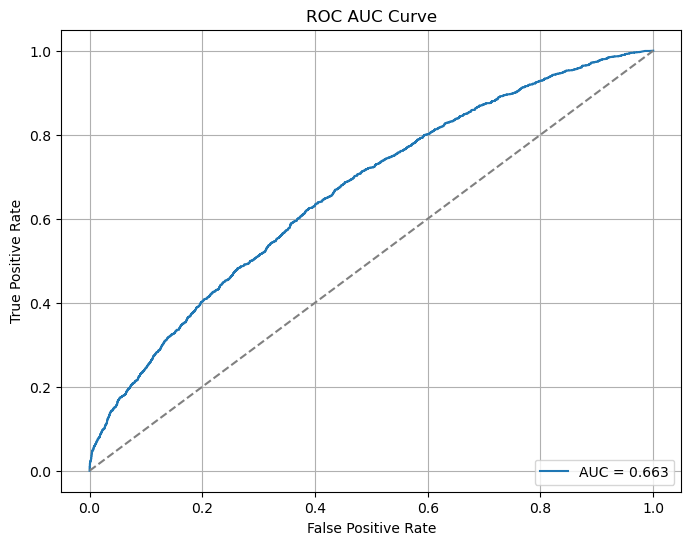

In [134]:

# Assume you have:
# y_true = true labels (0/1)
# y_prob = predicted probabilities for class 1

# Step 1: Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 2: Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Hyperparameter Tuning for Classification Model  
Performed a grid search with cross-validation to optimize the `HistGradientBoostingClassifier` using AUC as the scoring metric. The best model was evaluated on the test set using ROC AUC and classification metrics.

In [ ]:
# 1. Define your model
model = HistGradientBoostingClassifier(random_state=42)

# 2. Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 500],
    'max_leaf_nodes': [15, 31, 63],
    'min_samples_leaf': [10, 20, 50],
    'l2_regularization': [0, 1, 5]
}

# 3. Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',    # You can also use 'accuracy', 'f1', etc.
    cv=5,                 # 5-fold cross-validation
    verbose=2,
    n_jobs=-1             # Use all CPU cores
)

# 4. Fit it
grid_search.fit(X_train, y_train)

# 5. Best params and score
print("Best AUC Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 6. Predict on validation/test set
y_pred = grid_search.predict(X_test)
y_pred_prob = grid_search.predict_proba(X_test)[:,1]

# 7. Evaluate
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred))

### Grid Search Results Summary  
Collected and sorted all cross-validation results from the hyperparameter tuning process into a DataFrame for inspection and tracking. Exported results to a CSV for future reference and reproducibility.



In [ ]:
# 5. Now get all results into a dataframe
results_df = pd.DataFrame(grid_search.cv_results_)

# 6. Select only useful columns
results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# 7. Sort by best performance
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# 8. Display the full results
pd.set_option('display.max_rows', 200)   # Show more rows if needed
print(results_df)

# 9. Optional: Save to CSV for full tracking
results_df.to_csv('gridsearch_all_model_iterations.csv', index=False)

In [ ]:
results_df

### Visualizing Prediction Confidence
Plotted the histogram of predicted probabilities for being in the top 20. This distribution helps assess the model's confidence and calibration—wider spread and peaks near 0 or 1 suggest strong prediction certainty

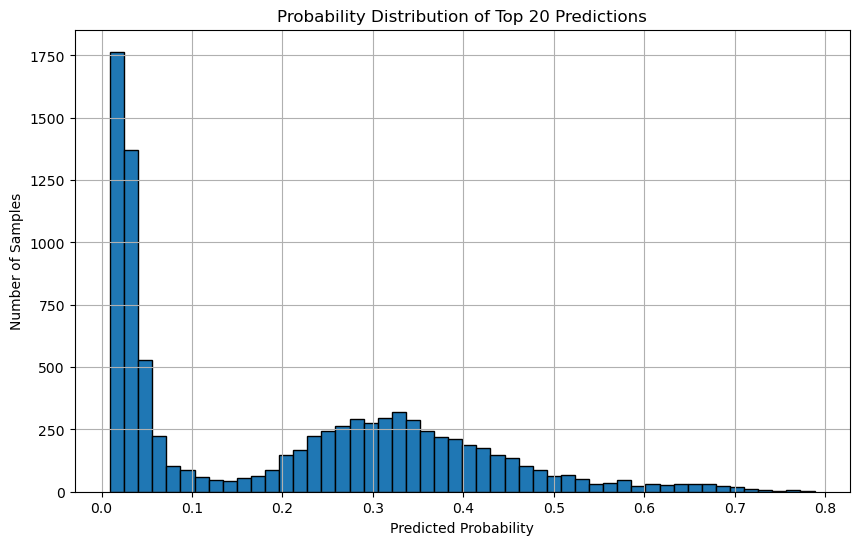

In [68]:
# Assuming y_pred_prob is your predicted probability for class 1 (Top 20)
# If you have predict_proba output, select the second column
# y_pred_prob = model.predict_proba(X_val)[:, 1]

plt.figure(figsize=(10, 6))
plt.hist(y_prob, bins=50, edgecolor='k')
plt.title('Probability Distribution of Top 20 Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()


### Threshold Optimization for Top-20 Classification
Swept through thresholds from 0.0 to 1.0 to evaluate precision, recall, and F1 score at each. This helps select the best probability cutoff based on your preferred trade-off—e.g., maximizing F1 for balanced performance.

In [69]:
def threshold_sweep(y_true, y_pred_prob, thresholds=np.arange(0.0, 1.01, 0.01)):
    """
    Scans multiple thresholds and calculates precision, recall, f1 for each.
    """
    results = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_pred_prob >= thresh).astype(int)
        
        precision = precision_score(y_true, y_pred_thresh, zero_division=0)
        recall = recall_score(y_true, y_pred_thresh, zero_division=0)
        f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
        
        results.append({
            'threshold': thresh,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    
    return pd.DataFrame(results)

# Example usage:

# After you have your predictions:
# y_pred_prob = model.predict_proba(X_val)[:, 1]

threshold_results = threshold_sweep(y_test, y_prob)

# Sort by F1 score to find best balance
threshold_results.sort_values('f1_score', ascending=False, inplace=True)

print(threshold_results.head(20))  # Top 20 threshold candidates


    threshold  precision    recall  f1_score
,25       0.25   0.381599  0.825846  0.521998
,22       0.22   0.368031  0.882418  0.519425
,23       0.23   0.370722  0.865225  0.519048
,26       0.26   0.383938  0.798114  0.518465
,24       0.24   0.373648  0.843039  0.517799
,27       0.27   0.388780  0.772601  0.517267
,28       0.28   0.395821  0.745979  0.517208
,21       0.21   0.363410  0.891292  0.516305
,20       0.20   0.359389  0.900166  0.513689
,19       0.19   0.355638  0.907931  0.511083
,29       0.29   0.398506  0.709928  0.510469
,18       0.18   0.353929  0.911814  0.509926
,16       0.16   0.351883  0.922352  0.509420
,17       0.17   0.352089  0.916251  0.508699
,30       0.30   0.404864  0.683306  0.508461
,15       0.15   0.350000  0.924016  0.507695
,14       0.14   0.348798  0.925679  0.506679
,13       0.13   0.348070  0.930116  0.506570
,31       0.31   0.411950  0.653910  0.505466
,12       0.12   0.346758  0.931226  0.505342


In [70]:
threshold_results=threshold_results.sort_values(by='threshold',ascending=1)

### Threshold Performance Visualization
Plotted Precision, Recall, and F1 Score across probability thresholds to identify the optimal decision boundary.
This helps choose a threshold based on your preference—higher recall (catch more top-20 players), higher precision (fewer false positives), or a balanced F1

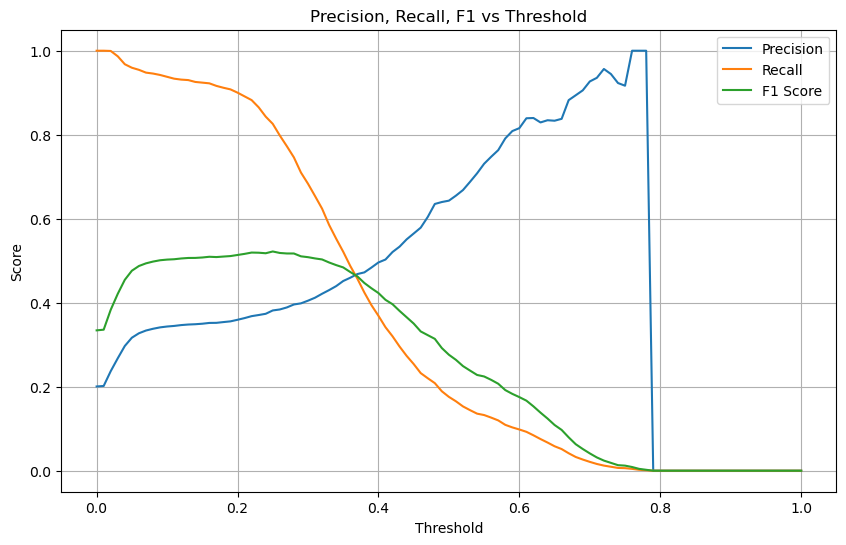

In [71]:
plt.figure(figsize=(10,6))
plt.plot(threshold_results['threshold'], threshold_results['precision'], label='Precision')
plt.plot(threshold_results['threshold'], threshold_results['recall'], label='Recall')
plt.plot(threshold_results['threshold'], threshold_results['f1_score'], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
 model.predict_proba(X_test)

In [ ]:
y_pred

In [ ]:
y_pred_prob

In [ ]:
X.shape

In [ ]:
test.shape

In [73]:
test2=test.dropna()
test2.shape

(18439, 262)

### Defining Input Features and Target Variable:**

- The code assigns a comprehensive set of golf-related statistics, course details, and environmental conditions to `X` as input features.  
- The target variable `y` is defined as the player's `round_score`, representing the score for each round of golf.

In [129]:
# Define input features and target
X = test2[['teetime_hour','last_score', 'teetime_hour_score',
       'last_sg_putt', 'last_sg_arg', 'last_sg_app', 'last_sg_ott',
       'last_sg_t2g', 'last_sg_total', 'last_driving_dist', 'last_driving_acc',
       'last_gir', 'last_scrambling', 'last_prox_rgh', 'last_prox_fw',
       'last_great_shots', 'last_poor_shots', 'score_lesr',
       'teetime_hour_lesr', 'sg_putt_lesr', 'sg_arg_lesr', 'sg_app_lesr',
       'sg_ott_lesr', 'sg_t2g_lesr', 'sg_total_lesr', 'driving_dist_lesr',
       'driving_acc_lesr', 'gir_lesr', 'scrambling_lesr', 'prox_rgh_lesr',
       'prox_fw_lesr', 'great_shots_lesr', 'poor_shots_lesr',
         'sg_putt_mean_3', 'sg_arg_mean_3', 'sg_app_mean_3', 'sg_ott_mean_3', 'sg_t2g_mean_3', 'sg_total_mean_3',
    'driving_dist_mean_3', 'driving_acc_mean_3', 'gir_mean_3', 'scrambling_mean_3', 'prox_rgh_mean_3', 'prox_fw_mean_3',
    'great_shots_mean_3', 'poor_shots_mean_3', 'round_score_mean_3',
    'sg_putt_avg_5', 'sg_arg_avg_5', 'sg_app_avg_5', 'sg_ott_avg_5', 'sg_t2g_avg_5', 'sg_total_avg_5',
    'driving_dist_avg_5', 'driving_acc_avg_5', 'gir_avg_5', 'scrambling_avg_5', 'prox_rgh_avg_5', 'prox_fw_avg_5',
    'great_shots_avg_5', 'poor_shots_avg_5', 'round_score_avg_5',
          
    'sg_putt_avg_last_1_tour', 'sg_arg_avg_last_1_tour', 'sg_app_avg_last_1_tour',
    'sg_ott_avg_last_1_tour', 'sg_t2g_avg_last_1_tour', 'sg_total_avg_last_1_tour',
    'driving_dist_avg_last_1_tour', 'driving_acc_avg_last_1_tour', 'gir_avg_last_1_tour',
    'scrambling_avg_last_1_tour', 'prox_rgh_avg_last_1_tour', 'prox_fw_avg_last_1_tour',
    'great_shots_avg_last_1_tour', 'poor_shots_avg_last_1_tour', 'round_score_avg_last_1_tour',

    'sg_putt_avg_last_3_tours', 'sg_arg_avg_last_3_tours', 'sg_app_avg_last_3_tours',
    'sg_ott_avg_last_3_tours', 'sg_t2g_avg_last_3_tours', 'sg_total_avg_last_3_tours',
    'driving_dist_avg_last_3_tours', 'driving_acc_avg_last_3_tours', 'gir_avg_last_3_tours',
    'scrambling_avg_last_3_tours', 'prox_rgh_avg_last_3_tours', 'prox_fw_avg_last_3_tours',
    'great_shots_avg_last_3_tours', 'poor_shots_avg_last_3_tours', 'round_score_avg_last_3_tours',

    'sg_putt_avg_last_5_tours', 'sg_arg_avg_last_5_tours', 'sg_app_avg_last_5_tours',
    'sg_ott_avg_last_5_tours', 'sg_t2g_avg_last_5_tours', 'sg_total_avg_last_5_tours',
    'driving_dist_avg_last_5_tours', 'driving_acc_avg_last_5_tours', 'gir_avg_last_5_tours',
    'scrambling_avg_last_5_tours', 'prox_rgh_avg_last_5_tours', 'prox_fw_avg_last_5_tours',
    'great_shots_avg_last_5_tours', 'poor_shots_avg_last_5_tours', 'round_score_avg_last_5_tours',
    
    'sg_putt_avg_last_10_tours','sg_arg_avg_last_10_tours','sg_app_avg_last_10_tours','sg_ott_avg_last_10_tours',
    'sg_t2g_avg_last_10_tours','sg_total_avg_last_10_tours','driving_dist_avg_last_10_tours','driving_acc_avg_last_10_tours',
    'gir_avg_last_10_tours','scrambling_avg_last_10_tours','prox_rgh_avg_last_10_tours','prox_fw_avg_last_10_tours',
    'great_shots_avg_last_10_tours','poor_shots_avg_last_10_tours','round_score_avg_last_10_tours',
    
    'ytd_tournament_counts','Humidity (%)','cleaned_temperature','cleaned_wind_speed',
    'sunny','raining','foggy','humid','breezy','dry','warm','hot','cool','mild','coastal','tropical',
         
    # Weighted proximity + sg_putt interactions
    'weighted_proximity_last', 'weighted_proximity_x_sg_putt_last',
    'weighted_proximity_lesr', 'weighted_proximity_x_sg_putt_lesr',
    'weighted_proximity_mean_3', 'weighted_proximity_x_sg_putt_mean_3',
    'weighted_proximity_avg_5', 'weighted_proximity_x_sg_putt_avg_5',
    'weighted_proximity_avg_last_1_tour', 'weighted_proximity_x_sg_putt_avg_last_1_tour',
    'weighted_proximity_avg_last_3_tours', 'weighted_proximity_x_sg_putt_avg_last_3_tours',
    'weighted_proximity_avg_last_5_tours', 'weighted_proximity_x_sg_putt_avg_last_5_tours',
    'weighted_proximity_avg_last_10_tours', 'weighted_proximity_x_sg_putt_avg_last_10_tours',

    # Wind × Driving Distance
    'wind_x_driving_dist_last', 'wind_x_driving_dist_lesr', 'wind_x_driving_dist_mean_3',
    'wind_x_driving_dist_avg_5', 'wind_x_driving_dist_avg_last_1_tour',
    'wind_x_driving_dist_avg_last_3_tours', 'wind_x_driving_dist_avg_last_5_tours',
    'wind_x_driving_dist_avg_last_10_tours',

    # Humidity × Weighted Proximity
    'humidity_x_weighted_prox_last', 'humidity_x_weighted_prox_lesr', 'humidity_x_weighted_prox_mean_3',
    'humidity_x_weighted_prox_avg_5', 'humidity_x_weighted_prox_avg_last_1_tour',
    'humidity_x_weighted_prox_avg_last_3_tours', 'humidity_x_weighted_prox_avg_last_5_tours',
    'humidity_x_weighted_prox_avg_last_10_tours',

    # Temperature × SG Putt
    'temp_x_sg_putt_last', 'temp_x_sg_putt_lesr', 'temp_x_sg_putt_mean_3',
    'temp_x_sg_putt_avg_5', 'temp_x_sg_putt_avg_last_1_tour',
    'temp_x_sg_putt_avg_last_3_tours', 'temp_x_sg_putt_avg_last_5_tours',
    'temp_x_sg_putt_avg_last_10_tours',
    
    # round_score averages
    'last_1_year_round_score_course_avg',
    'last_3_year_round_score_course_avg',
    'last_5_year_round_score_course_avg',

    # sg_putt averages
    'last_1_year_sg_putt_course_avg',
    'last_3_year_sg_putt_course_avg',
    'last_5_year_sg_putt_course_avg',

    # sg_arg averages
    'last_1_year_sg_arg_course_avg',
    'last_3_year_sg_arg_course_avg',
    'last_5_year_sg_arg_course_avg',

    # sg_app averages
    'last_1_year_sg_app_course_avg',
    'last_3_year_sg_app_course_avg',
    'last_5_year_sg_app_course_avg',

    # sg_ott averages
    'last_1_year_sg_ott_course_avg',
    'last_3_year_sg_ott_course_avg',
    'last_5_year_sg_ott_course_avg',

    # sg_t2g averages
    'last_1_year_sg_t2g_course_avg',
    'last_3_year_sg_t2g_course_avg',
    'last_5_year_sg_t2g_course_avg',

    # sg_total averages
    'last_1_year_sg_total_course_avg',
    'last_3_year_sg_total_course_avg',
    'last_5_year_sg_total_course_avg',

    # driving_dist averages
    'last_1_year_driving_dist_course_avg',
    'last_3_year_driving_dist_course_avg',
    'last_5_year_driving_dist_course_avg',

    # driving_acc averages
    'last_1_year_driving_acc_course_avg',
    'last_3_year_driving_acc_course_avg',
    'last_5_year_driving_acc_course_avg',

    # gir averages
    'last_1_year_gir_course_avg',
    'last_3_year_gir_course_avg',
    'last_5_year_gir_course_avg',

    # scrambling averages
    'last_1_year_scrambling_course_avg',
    'last_3_year_scrambling_course_avg',
    'last_5_year_scrambling_course_avg',

    # prox_rgh averages
    'last_1_year_prox_rgh_course_avg',
    'last_3_year_prox_rgh_course_avg',
    'last_5_year_prox_rgh_course_avg',

    # prox_fw averages
    'last_1_year_prox_fw_course_avg',
    'last_3_year_prox_fw_course_avg',
    'last_5_year_prox_fw_course_avg',

    # great_shots averages
    'last_1_year_great_shots_course_avg',
    'last_3_year_great_shots_course_avg',
    'last_5_year_great_shots_course_avg',

    # poor_shots averages
    'last_1_year_poor_shots_course_avg',
    'last_3_year_poor_shots_course_avg',
    'last_5_year_poor_shots_course_avg',
         
    'made_cut_last10', 'made_cut_last20', 'made_cut_last50', 'made_cut_ytd',
                                                                
    'course_rating', 'slope','acres_of_fairway', 'acres_of_rough',
                                                                
    'is_bentgrass_greens', 'is_bermuda_greens', 'is_poa_annua_greens', 'is_fescue_greens', 'is_paspalum_greens',
    'is_kikuyu_greens', 'is_zoysiagrass_fairway', 'is_fescue_fairway', 'is_bentgrass_fairway', 'is_bermuda_fairway',
 'is_ryegrass_fairway', 'is_kikuyu_fairway', 'is_poa_annua_fairway', 'is_bluegrass_fairway', 'is_paspalum_fairway',
    
    'round_1','round_2','round_3','round_4']]
y = test2['round_score']

### Fitting and Evaluating an OLS Regression Model**

The code fits an OLS regression model with the input features `X` and target `y`, evaluates performance using R² and RMSE, and prints a detailed model summary with coefficients and p-values.

In [135]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Step 1: Add intercept to X
X_const = sm.add_constant(X)

# Step 2: Fit OLS model
model = sm.OLS(y, X_const).fit()

# Step 3: Predict using the model
y_pred = model.predict(X_const)

# Step 4: Evaluation Metrics
r2 = model.rsquared
rmse = np.sqrt(np.mean((y - y_pred) ** 2))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Step 5: Detailed model summary (includes coefficients and p-values)
print(model.summary())


MissingDataError: exog contains inf or nans

#### Data Preprocessing and Feature Selection for Regression Analysis**

This code prepares the dataset by removing any rows with missing values, defines a comprehensive set of input features `X`, and selects the target variable `y` for predicting the `round_score`. The selected features include various golf statistics, weather conditions, and course-related attributes.

In [148]:
test2=test.dropna()
print(test2.shape)

# Define input features and target
X = test2[['teetime_hour','last_score', 'teetime_hour_score',
       'last_sg_putt', 'last_sg_arg', 'last_sg_app', 'last_sg_ott',
       'last_sg_t2g', 'last_sg_total', 'last_driving_dist', 'last_driving_acc',
       'last_gir', 'last_scrambling', 'last_prox_rgh', 'last_prox_fw',
       'last_great_shots', 'last_poor_shots', 'score_lesr',
       'teetime_hour_lesr', 'sg_putt_lesr', 'sg_arg_lesr', 'sg_app_lesr',
       'sg_ott_lesr', 'sg_t2g_lesr', 'sg_total_lesr', 'driving_dist_lesr',
       'driving_acc_lesr', 'gir_lesr', 'scrambling_lesr', 'prox_rgh_lesr',
       'prox_fw_lesr', 'great_shots_lesr', 'poor_shots_lesr',
         'sg_putt_mean_3', 'sg_arg_mean_3', 'sg_app_mean_3', 'sg_ott_mean_3', 'sg_t2g_mean_3', 'sg_total_mean_3',
    'driving_dist_mean_3', 'driving_acc_mean_3', 'gir_mean_3', 'scrambling_mean_3', 'prox_rgh_mean_3', 'prox_fw_mean_3',
    'great_shots_mean_3', 'poor_shots_mean_3', 'round_score_mean_3',
    'sg_putt_avg_5', 'sg_arg_avg_5', 'sg_app_avg_5', 'sg_ott_avg_5', 'sg_t2g_avg_5', 'sg_total_avg_5',
    'driving_dist_avg_5', 'driving_acc_avg_5', 'gir_avg_5', 'scrambling_avg_5', 'prox_rgh_avg_5', 'prox_fw_avg_5',
    'great_shots_avg_5', 'poor_shots_avg_5', 'round_score_avg_5',
          
    'sg_putt_avg_last_1_tour', 'sg_arg_avg_last_1_tour', 'sg_app_avg_last_1_tour',
    'sg_ott_avg_last_1_tour', 'sg_t2g_avg_last_1_tour', 'sg_total_avg_last_1_tour',
    'driving_dist_avg_last_1_tour', 'driving_acc_avg_last_1_tour', 'gir_avg_last_1_tour',
    'scrambling_avg_last_1_tour', 'prox_rgh_avg_last_1_tour', 'prox_fw_avg_last_1_tour',
    'great_shots_avg_last_1_tour', 'poor_shots_avg_last_1_tour', 'round_score_avg_last_1_tour',

    'sg_putt_avg_last_3_tours', 'sg_arg_avg_last_3_tours', 'sg_app_avg_last_3_tours',
    'sg_ott_avg_last_3_tours', 'sg_t2g_avg_last_3_tours', 'sg_total_avg_last_3_tours',
    'driving_dist_avg_last_3_tours', 'driving_acc_avg_last_3_tours', 'gir_avg_last_3_tours',
    'scrambling_avg_last_3_tours', 'prox_rgh_avg_last_3_tours', 'prox_fw_avg_last_3_tours',
    'great_shots_avg_last_3_tours', 'poor_shots_avg_last_3_tours', 'round_score_avg_last_3_tours',

    'sg_putt_avg_last_5_tours', 'sg_arg_avg_last_5_tours', 'sg_app_avg_last_5_tours',
    'sg_ott_avg_last_5_tours', 'sg_t2g_avg_last_5_tours', 'sg_total_avg_last_5_tours',
    'driving_dist_avg_last_5_tours', 'driving_acc_avg_last_5_tours', 'gir_avg_last_5_tours',
    'scrambling_avg_last_5_tours', 'prox_rgh_avg_last_5_tours', 'prox_fw_avg_last_5_tours',
    'great_shots_avg_last_5_tours', 'poor_shots_avg_last_5_tours', 'round_score_avg_last_5_tours',
    
    'sg_putt_avg_last_10_tours','sg_arg_avg_last_10_tours','sg_app_avg_last_10_tours','sg_ott_avg_last_10_tours',
    'sg_t2g_avg_last_10_tours','sg_total_avg_last_10_tours','driving_dist_avg_last_10_tours','driving_acc_avg_last_10_tours',
    'gir_avg_last_10_tours','scrambling_avg_last_10_tours','prox_rgh_avg_last_10_tours','prox_fw_avg_last_10_tours',
    'great_shots_avg_last_10_tours','poor_shots_avg_last_10_tours','round_score_avg_last_10_tours',
    
    'ytd_tournament_counts','Humidity (%)','cleaned_temperature','cleaned_wind_speed',
    'sunny','raining','foggy','humid','breezy','dry','warm','hot','cool','mild','coastal','tropical',
         
    # Weighted proximity + sg_putt interactions
    'weighted_proximity_last', 'weighted_proximity_x_sg_putt_last',
    'weighted_proximity_lesr', 'weighted_proximity_x_sg_putt_lesr',
    'weighted_proximity_mean_3', 'weighted_proximity_x_sg_putt_mean_3',
    'weighted_proximity_avg_5', 'weighted_proximity_x_sg_putt_avg_5',
    'weighted_proximity_avg_last_1_tour', 'weighted_proximity_x_sg_putt_avg_last_1_tour',
    'weighted_proximity_avg_last_3_tours', 'weighted_proximity_x_sg_putt_avg_last_3_tours',
    'weighted_proximity_avg_last_5_tours', 'weighted_proximity_x_sg_putt_avg_last_5_tours',
    'weighted_proximity_avg_last_10_tours', 'weighted_proximity_x_sg_putt_avg_last_10_tours',

    # Wind × Driving Distance
    'wind_x_driving_dist_last', 'wind_x_driving_dist_lesr', 'wind_x_driving_dist_mean_3',
    'wind_x_driving_dist_avg_5', 'wind_x_driving_dist_avg_last_1_tour',
    'wind_x_driving_dist_avg_last_3_tours', 'wind_x_driving_dist_avg_last_5_tours',
    'wind_x_driving_dist_avg_last_10_tours',

    # Humidity × Weighted Proximity
    'humidity_x_weighted_prox_last', 'humidity_x_weighted_prox_lesr', 'humidity_x_weighted_prox_mean_3',
    'humidity_x_weighted_prox_avg_5', 'humidity_x_weighted_prox_avg_last_1_tour',
    'humidity_x_weighted_prox_avg_last_3_tours', 'humidity_x_weighted_prox_avg_last_5_tours',
    'humidity_x_weighted_prox_avg_last_10_tours',

    # Temperature × SG Putt
    'temp_x_sg_putt_last', 'temp_x_sg_putt_lesr', 'temp_x_sg_putt_mean_3',
    'temp_x_sg_putt_avg_5', 'temp_x_sg_putt_avg_last_1_tour',
    'temp_x_sg_putt_avg_last_3_tours', 'temp_x_sg_putt_avg_last_5_tours',
    'temp_x_sg_putt_avg_last_10_tours',
    
    # round_score averages
    'last_1_year_round_score_course_avg',
    'last_3_year_round_score_course_avg',
    'last_5_year_round_score_course_avg',

    # sg_putt averages
    'last_1_year_sg_putt_course_avg',
    'last_3_year_sg_putt_course_avg',
    'last_5_year_sg_putt_course_avg',

    # sg_arg averages
    'last_1_year_sg_arg_course_avg',
    'last_3_year_sg_arg_course_avg',
    'last_5_year_sg_arg_course_avg',

    # sg_app averages
    'last_1_year_sg_app_course_avg',
    'last_3_year_sg_app_course_avg',
    'last_5_year_sg_app_course_avg',

    # sg_ott averages
    'last_1_year_sg_ott_course_avg',
    'last_3_year_sg_ott_course_avg',
    'last_5_year_sg_ott_course_avg',

    # sg_t2g averages
    'last_1_year_sg_t2g_course_avg',
    'last_3_year_sg_t2g_course_avg',
    'last_5_year_sg_t2g_course_avg',

    # sg_total averages
    'last_1_year_sg_total_course_avg',
    'last_3_year_sg_total_course_avg',
    'last_5_year_sg_total_course_avg',

    # driving_dist averages
    'last_1_year_driving_dist_course_avg',
    'last_3_year_driving_dist_course_avg',
    'last_5_year_driving_dist_course_avg',

    # driving_acc averages
    'last_1_year_driving_acc_course_avg',
    'last_3_year_driving_acc_course_avg',
    'last_5_year_driving_acc_course_avg',

    # gir averages
    'last_1_year_gir_course_avg',
    'last_3_year_gir_course_avg',
    'last_5_year_gir_course_avg',

    # scrambling averages
    'last_1_year_scrambling_course_avg',
    'last_3_year_scrambling_course_avg',
    'last_5_year_scrambling_course_avg',

    # prox_rgh averages
    'last_1_year_prox_rgh_course_avg',
    'last_3_year_prox_rgh_course_avg',
    'last_5_year_prox_rgh_course_avg',

    # prox_fw averages
    'last_1_year_prox_fw_course_avg',
    'last_3_year_prox_fw_course_avg',
    'last_5_year_prox_fw_course_avg',

    # great_shots averages
    'last_1_year_great_shots_course_avg',
    'last_3_year_great_shots_course_avg',
    'last_5_year_great_shots_course_avg',

    # poor_shots averages
    'last_1_year_poor_shots_course_avg',
    'last_3_year_poor_shots_course_avg',
    'last_5_year_poor_shots_course_avg',
         
    'made_cut_last10', 'made_cut_last20', 'made_cut_last50', 'made_cut_ytd',
                                                                
    'course_rating', 'slope','acres_of_fairway', 'acres_of_rough',
                                                                
    'is_bentgrass_greens', 'is_bermuda_greens', 'is_poa_annua_greens', 'is_fescue_greens', 'is_paspalum_greens',
    'is_kikuyu_greens', 'is_zoysiagrass_fairway', 'is_fescue_fairway', 'is_bentgrass_fairway', 'is_bermuda_fairway',
 'is_ryegrass_fairway', 'is_kikuyu_fairway', 'is_poa_annua_fairway', 'is_bluegrass_fairway', 'is_paspalum_fairway',
    
    'round_1','round_2','round_3','round_4']]
y = test2['round_score']

(18439, 262)


In [149]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Backward Elimination for Feature Selection in Regression Models**

This code performs backward elimination for feature selection in a regression analysis. It starts by fitting an OLS model, then iteratively removes the least significant feature (based on the highest p-value) if its p-value exceeds a predefined threshold (default 0.05). The process continues until all remaining features have p-values below the threshold, ensuring only statistically significant predictors are included in the final model. The final model summary is then printed.

In [150]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

def backward_elimination(X, y, threshold=0.05):
    # Only numeric columns, drop NaNs
    X = X.select_dtypes(include=[np.number]).dropna()
    y = y.loc[X.index]

    # Add constant
    X = sm.add_constant(X)

    while True:
        model = sm.OLS(y, X).fit()
        pvals = model.pvalues.drop('const', errors='ignore')  # exclude intercept
        max_p = pvals.max()

        if max_p > threshold:
            worst_feature = pvals.idxmax()
            print(f"Removing: {worst_feature} (p = {max_p:.4f})")
            X = X.drop(columns=worst_feature)
        else:
            break

    return model

# Run backward elimination
final_model = backward_elimination(X_train, y_train)

# Final summary
print("\nFinal model summary:")
print(final_model.summary())


Removing: weighted_proximity_x_sg_putt_avg_last_5_tours (p = 0.9928)
,Removing: humidity_x_weighted_prox_avg_last_5_tours (p = 0.9906)
,Removing: weighted_proximity_x_sg_putt_lesr (p = 0.9848)
,Removing: prox_rgh_lesr (p = 0.9760)
,Removing: last_sg_ott (p = 0.9744)
,Removing: gir_lesr (p = 0.9683)
,Removing: wind_x_driving_dist_avg_last_5_tours (p = 0.9606)
,Removing: wind_x_driving_dist_avg_last_3_tours (p = 0.9761)
,Removing: temp_x_sg_putt_mean_3 (p = 0.9544)
,Removing: humid (p = 0.9477)
,Removing: raining (p = 0.9575)
,Removing: is_kikuyu_greens (p = 0.9803)
,Removing: driving_acc_avg_last_5_tours (p = 0.9382)
,Removing: temp_x_sg_putt_avg_last_3_tours (p = 0.9342)
,Removing: last_1_year_sg_app_course_avg (p = 0.9318)
,Removing: last_3_year_poor_shots_course_avg (p = 0.9316)
,Removing: humidity_x_weighted_prox_avg_last_3_tours (p = 0.9066)
,Removing: last_scrambling (p = 0.8920)
,Removing: great_shots_avg_last_1_tour (p = 0.8914)
,Removing: round_score_avg_5 (p = 0.8857)
,Removin

### Model Evaluation with RMSE on Test Data**

This code calculates the Root Mean Squared Error (RMSE) on the test dataset after performing feature selection using backward elimination. It removes the intercept ('const') from the feature list, prepares the test data with the selected features, and adds the intercept term. Then, it predicts the target variable on the test set and computes the RMSE to evaluate the model's performance. The lower the RMSE, the better the model fits the test data.

In [151]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Remove 'const' from feature list
final_features = [f for f in final_model.model.exog_names if f != 'const']

# Step 2: Prepare X_test
X_test_selected = X_test[final_features].copy()
X_test_selected = sm.add_constant(X_test_selected)  # add intercept

# Step 3: Predict
y_pred = final_model.predict(X_test_selected)

# Step 4: Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 2.8834


In [144]:
i=1

#### Feature Ranking by Influence**

This code ranks the features based on the magnitude of their coefficients in the final model. By dropping the intercept ('const'), it sorts the remaining features according to the absolute value of their coefficients, with the most influential features appearing at the top. The list of top features is printed, showing both the coefficients and their names in descending order of their influence on the model's predictions. This helps identify which variables have the strongest impact on the target variable.

In [153]:
# Drop intercept
coef_series = final_model.params.drop('const', errors='ignore')

# Sort by absolute value (influence)
ranked_features = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

# Display as list
top_features_list = ranked_features.index.tolist()

# Show with coefficients (optional)
print(ranked_features)

# If you just want the names:
print("\nTop features by influence (most to least):")
print(top_features_list)


last_5_year_sg_total_course_avg        7.462337e+03
,last_3_year_sg_total_course_avg       -6.228832e+03
,last_5_year_sg_ott_course_avg         -3.159752e+03
,last_5_year_sg_arg_course_avg          2.605068e+03
,last_3_year_sg_arg_course_avg         -1.415887e+03
,last_1_year_sg_ott_course_avg          7.609844e+02
,last_3_year_sg_app_course_avg          7.040435e+02
,last_5_year_sg_putt_course_avg         5.157131e+02
,last_5_year_sg_t2g_course_avg          3.762997e+02
,last_1_year_sg_t2g_course_avg         -2.504160e+02
,last_1_year_sg_putt_course_avg        -1.257158e+02
,last_1_year_sg_arg_course_avg          9.788425e+01
,last_5_year_gir_course_avg            -8.553181e+01
,last_3_year_gir_course_avg             8.299415e+01
,last_3_year_scrambling_course_avg      2.223877e+01
,last_1_year_scrambling_course_avg     -1.607581e+01
,round_2                               -1.245315e+01
,round_1                               -1.241332e+01
,last_1_year_driving_acc_course_avg     7.54551

In [86]:
final_features

['const',
 'teetime_hour',
 'last_sg_putt',
 'last_sg_app',
 'last_sg_t2g',
 'last_driving_dist',
 'score_lesr',
 'sg_putt_lesr',
 'sg_t2g_lesr',
 'sg_total_lesr',
 'poor_shots_lesr',
 'sg_t2g_mean_3',
 'sg_arg_avg_5',
 'sg_app_avg_5',
 'sg_ott_avg_5',
 'sg_t2g_avg_5',
 'sg_total_avg_5',
 'driving_dist_avg_5',
 'sg_arg_avg_last_1_tour',
 'sg_app_avg_last_1_tour',
 'sg_ott_avg_last_1_tour',
 'sg_t2g_avg_last_1_tour',
 'sg_total_avg_last_1_tour',
 'prox_fw_avg_last_1_tour',
 'round_score_avg_last_1_tour',
 'sg_total_avg_last_3_tours',
 'sg_arg_avg_last_5_tours',
 'sg_app_avg_last_5_tours',
 'sg_ott_avg_last_5_tours',
 'sg_t2g_avg_last_5_tours',
 'gir_avg_last_5_tours',
 'round_score_avg_last_5_tours',
 'sg_putt_avg_last_10_tours',
 'sg_arg_avg_last_10_tours',
 'sg_app_avg_last_10_tours',
 'sg_ott_avg_last_10_tours',
 'great_shots_avg_last_10_tours',
 'ytd_tournament_counts',
 'Humidity (%)',
 'cleaned_temperature',
 'cleaned_wind_speed',
 'sunny',
 'foggy',
 'breezy',
 'dry',
 'warm',
 '

# Logistic Regression

## Data Preparation and Train-Test Split**

This code prepares the dataset by selecting relevant features and the target variable for prediction. It then splits the data into training and test sets using an 80-20 split for model evaluation.

In [180]:
test2=test.dropna()
print(test2.shape)

# Define input features and target
X = test2[[
 'teetime_hour',
 'last_sg_putt',
 'last_sg_app',
 'last_sg_t2g',
 'last_driving_dist',
 'score_lesr',
 'sg_putt_lesr',
 'sg_t2g_lesr',
 'sg_total_lesr',
 'poor_shots_lesr',
 'sg_t2g_mean_3',
 'sg_arg_avg_5',
 'sg_app_avg_5',
 'sg_ott_avg_5',
 'sg_t2g_avg_5',
 'sg_total_avg_5',
 'driving_dist_avg_5',
 'sg_arg_avg_last_1_tour',
 'sg_app_avg_last_1_tour',
 'sg_ott_avg_last_1_tour',
 'sg_t2g_avg_last_1_tour',
 'sg_total_avg_last_1_tour',
 'prox_fw_avg_last_1_tour',
 'round_score_avg_last_1_tour',
 'sg_total_avg_last_3_tours',
 'sg_arg_avg_last_5_tours',
 'sg_app_avg_last_5_tours',
 'sg_ott_avg_last_5_tours',
 'sg_t2g_avg_last_5_tours',
 'gir_avg_last_5_tours',
 'round_score_avg_last_5_tours',
 'sg_putt_avg_last_10_tours',
 'sg_arg_avg_last_10_tours',
 'sg_app_avg_last_10_tours',
 'sg_ott_avg_last_10_tours',
 'great_shots_avg_last_10_tours',
 'ytd_tournament_counts',
 'Humidity (%)',
 'cleaned_temperature',
 'cleaned_wind_speed',
 'sunny',
 'foggy',
 'breezy',
 'dry',
 'warm',
 'cool',
 'mild',
 'coastal',
 'weighted_proximity_mean_3',
 'weighted_proximity_x_sg_putt_mean_3',
 'wind_x_driving_dist_lesr',
 'wind_x_driving_dist_avg_5',
 'humidity_x_weighted_prox_mean_3',
 'last_1_year_round_score_course_avg',
 'last_3_year_round_score_course_avg',
 'last_1_year_sg_putt_course_avg',
 'last_3_year_sg_putt_course_avg',
 'last_5_year_sg_putt_course_avg',
 'last_5_year_sg_arg_course_avg',
 'last_3_year_sg_app_course_avg',
 'last_5_year_sg_app_course_avg',
 'last_1_year_sg_ott_course_avg',
 'last_3_year_sg_ott_course_avg',
 'last_5_year_sg_ott_course_avg'
]]
y = test2['is_top_20_round']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(18439, 262)


# Logistic Regression Model Fit**

This code fits a logistic regression model using the training dataset, with an added intercept term. It then displays the model summary, including coefficients and statistical significance for each feature.

In [181]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Step 2: Add intercept
X_const = sm.add_constant(X_train)

# Step 3: Fit logistic| regression
logit_model = sm.Logit(y_train, X_train).fit()

# Step 4: Model summary
print(logit_model.summary())


,         Current function value: inf
,         Iterations: 35
,                           Logit Regression Results                           
,==============================================================================
,Dep. Variable:        is_top_20_round   No. Observations:                14751
,Model:                          Logit   Df Residuals:                    14687
,Method:                           MLE   Df Model:                           63
,Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                    -inf
,Time:                        20:23:55   Log-Likelihood:                   -inf
,converged:                      False   LL-Null:                       -7585.7
,Covariance Type:            nonrobust   LLR p-value:                     1.000
,=======================================================================================================
,                                          coef    std err          z      P>|z|      [0.025      0.975]
,------

C:\Users\hp envy\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
,  return 1/(1+np.exp(-X))
,C:\Users\hp envy\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
,  return np.sum(np.log(self.cdf(q * linpred)))
,C:\Users\hp envy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
,  warnings.warn("Maximum Likelihood optimization failed to "
,C:\Users\hp envy\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
,  return 1/(1+np.exp(-X))


# Model Evaluation: AUC, Recall, and Precision**

This code evaluates the logistic regression model using three key metrics: AUC (Area Under the Curve), Recall, and Precision. The model's predictions are classified with a threshold of 0.5, and the results are printed for each metric to assess the model's performance on the test set.

In [186]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score

# Step 1: Predict probabilities using same structure as training (no intercept)
y_prob_test = logit_model.predict(X_test)  # DO NOT add constant

# Step 2: Classify using threshold (e.g. 0.5)
y_pred_test = (y_prob_test >= 0.5).astype(int)

# Step 3: Evaluate
auc = roc_auc_score(y_test, y_prob_test)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)

# Step 4: Print
print(f"AUC: {auc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


AUC: 0.5185
,Recall: 0.3716
,Precision: 0.2286


C:\Users\hp envy\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
,  return 1/(1+np.exp(-X))


# ROC Curve Evaluation**

This code plots the ROC curve for the logistic regression model, displaying the relationship between the True Positive Rate (TPR) and False Positive Rate (FPR) at various thresholds. The AUC score is included to assess the model's classification performance.

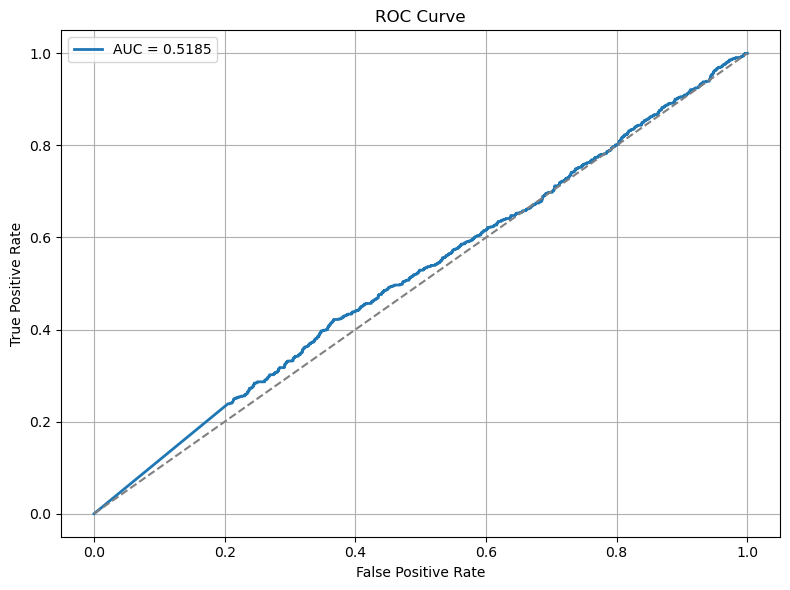

In [187]:
# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_test)
auc_score = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Precision-Recall-Threshold Curve**

This code generates a Precision-Recall-Threshold curve, plotting how precision, recall, and F1 score change as the classification threshold varies. It helps visualize the trade-off between precision and recall, with the F1 score providing a balanced metric for model performance.

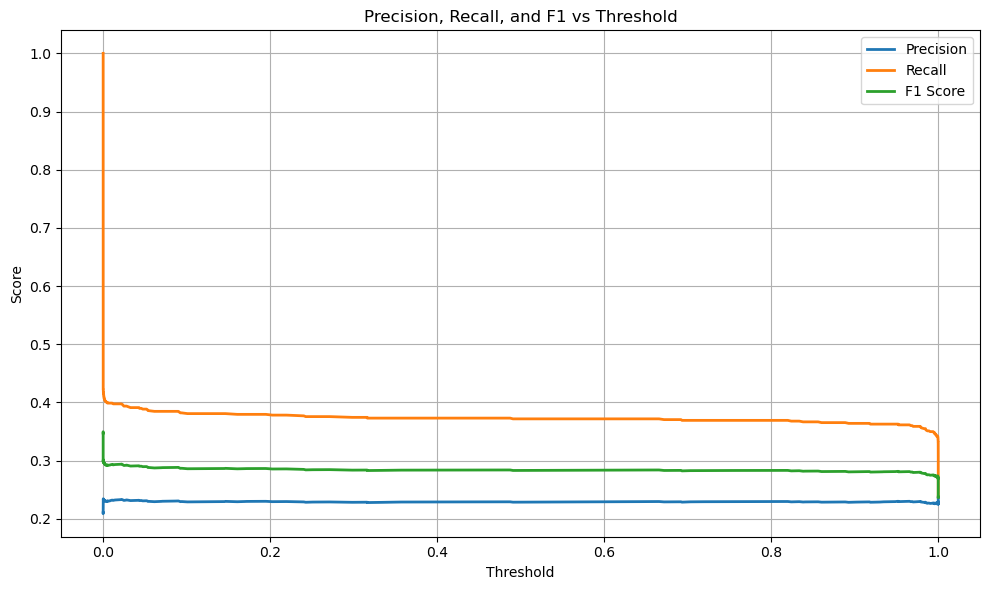

In [188]:
# Precision-Recall-Threshold Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
plt.plot(thresholds, f1[:-1], label='F1 Score', linewidth=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.T.drop_duplicates().T


# Find and remove one of any pair with correlation = 1.0
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] == 1.0)]

X = X.drop(columns=to_drop)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [158]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

full_X_train = X_train.copy()

X_train = X_train[['last_1_year_poor_shots_course_avg',
    'last_3_year_poor_shots_course_avg',
    'last_5_year_poor_shots_course_avg']]

### Finding Best Threshold Based on F1 Score**

This code identifies the threshold that maximizes the F1 score by evaluating precision and recall at different thresholds. It provides the best threshold, along with the corresponding precision, recall, and F1 score values, to optimize classification performance.

In [190]:
# Step 2: Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

# Step 3: Trim arrays to match threshold length
precision_vals = precision[:-1]
recall_vals = recall[:-1]
f1_vals = f1[:-1]
thresholds = thresholds

# Step 4: Find best F1 threshold
best_idx = np.argmax(f1_vals)
best_threshold = thresholds[best_idx]
best_f1 = f1_vals[best_idx]
best_precision = precision_vals[best_idx]
best_recall = recall_vals[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"F1 Score: {best_f1:.3f}")
print(f"Precision: {best_precision:.3f}")
print(f"Recall: {best_recall:.3f}")

Best Threshold: 0.00
,F1 Score: 0.349
,Precision: 0.212
,Recall: 0.986


### Optimizing Model with Best F1 Threshold**

This code evaluates the best threshold to maximize the F1 score by calculating precision, recall, and F1 values across different thresholds. It identifies the threshold that balances precision and recall to achieve the highest F1 score, providing key metrics for model optimization.

In [ ]:
# Step 2: Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

# Step 3: Trim arrays to match threshold length
precision_vals = precision[:-1]
recall_vals = recall[:-1]
f1_vals = f1[:-1]
thresholds = thresholds

# Step 4: Find best F1 threshold
best_idx = np.argmax(f1_vals)
best_threshold = thresholds[best_idx]
best_f1 = f1_vals[best_idx]
best_precision = precision_vals[best_idx]
best_recall = recall_vals[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"F1 Score: {best_f1:.3f}")
print(f"Precision: {best_precision:.3f}")
print(f"Recall: {best_recall:.3f}")